# Gibbs chain verification

In [51]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import healpy as hp
import astropy.io.fits as fits
import camb
import scipy
import toml
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import numpyro
from fgbuster.observation_helpers import *
import micmac as micmac

from jax import config
config.update("jax_enable_x64", True)

In [52]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')

In [53]:
working_directory_path = os.path.abspath('') + '/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'
directory_additional_params = working_directory_path + 'additional_params/'

# path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


# Studying the sampling !

In [54]:
sub_step_sampling = 50
num_jobs = 4
file_ver = 'biased_cutsky_v104_v1a_{}_{}'
path_additional_params = directory_additional_params + 'add_biased_cutsky_v1a.toml'
### Except for the last job, all seems biased -> the last one in particular seem to recover the good value of r ? Anyway, need to contibue

file_ver = 'corr_cutsky_v104_v1a_{}_{}'
path_additional_params = directory_additional_params + 'add_corr_cutsky_v1a.toml'
### Maybe start from a bit too close to the true value of B_f, and overall only negative r values recovered, a bit unclear if B_f converged

# file_ver = 'corr_cutsky_v104_v1ab_{}_{}'
# path_additional_params = directory_additional_params + 'add_corr_cutsky_v1ab.toml'
### Too similar to the previous one, but with a bit less negative r values -> need to see what fullsky will give

# file_ver = 'corr_cutsky_v104_v1b_{}_{}'
# path_additional_params = directory_additional_params + 'add_corr_cutsky_v1b.toml'
### Exact same problem as before, but seem coherent with it

# file_ver = 'corr_cutsky_v104_v1bb_{}_{}'
# path_additional_params = directory_additional_params + 'add_corr_cutsky_v1bb.toml'
### Too much the same as before

# file_ver = 'corr_cutsky_d7s0_v104_v1a_{}_{}'
# path_additional_params = directory_additional_params + 'add_corr_cutsky_d7s0_v1a.toml'
### Not converged at all, need to continue

# file_ver = 'corr_cutsky_d7s0_v104_v1b_{}_{}'
# path_additional_params = directory_additional_params + 'add_corr_cutsky_d7s0_v1b.toml'
### Same



# file_ver = 'corr_cutsky_inhom_v104_v1a_{}_{}'
# path_additional_params = directory_additional_params + 'add_corr_cutsky_inhom_v1a.toml'
### To relaunch

# file_ver = 'corr_cutsky_inhom_v104_v1b_{}_{}'
# path_additional_params = directory_additional_params + 'add_corr_cutsky_inhom_v1b.toml'
### To relaunch

In [55]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()

reduction_noise = dictionary_additional_parameters['reduction_noise']
# factor_Fisher = dictionary_additional_parameters['factor_Fisher']
# relative_treshold = dictionary_additional_parameters['relative_treshold']
# sigma_gap = dictionary_additional_parameters['sigma_gap']
fgs_model = dictionary_additional_parameters['fgs_model']
# initial_guess_r = dictionary_additional_parameters['initial_guess_r']
# use_nhits = dictionary_additional_parameters['use_nhits']
# name_mask = dictionary_additional_parameters['name_mask']
# use_mask = dictionary_additional_parameters['use_mask']
name_toml = dictionary_additional_parameters['name_toml']
print("Using toml file: ", name_toml)

Using toml file:  corr_cutsky_v1a.toml


In [56]:
path_toml_file = directory_toml_file + name_toml

In [57]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [58]:
if (MICMAC_sampler_obj.number_iterations_sampling > 100) and (sub_step_sampling==1):
    sub_step_sampling = 50
elif MICMAC_sampler_obj.number_iterations_sampling > 1000:
    sub_step_sampling = 100

In [59]:
NSIDE = MICMAC_sampler_obj.nside
# cmb_model = 'c1'
# fgs_model = 'd0s0'
# model = cmb_model+fgs_model
# noise = True
# noise = False
noise_seed = MICMAC_sampler_obj.seed
instr_name = MICMAC_sampler_obj.instrument_name

# get instrument from public database
instrument = get_instrument(instr_name)

# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=NSIDE, noise=True)[:, 1:, :]   # keep only Q and U


In [60]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [61]:
# input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)
_, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]

indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [62]:
initial_freq_maps = []
input_cmb_maps = []
all_eta_maps = []
all_s_c_WF_maps = []
all_s_c_fluct_maps = []
all_s_c_samples = []
all_r_samples = []
all_cell_samples = []
all_params_mixing_matrix_samples = []

for job in range(num_jobs):

    initial_freq_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_data.npy'
    initial_freq_maps.append(np.load(initial_freq_maps_path))

    initial_cmb_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_initial_cmb_data.npy'
    input_cmb_maps.append(np.load(initial_cmb_maps_path))
    if not(MICMAC_sampler_obj.cheap_save):
        all_eta_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_eta_maps.npy'
        all_eta_maps.append(np.load(all_eta_maps_path))

        all_s_c_WF_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c_WF_maps.npy'
        all_s_c_WF_maps.append(np.load(all_s_c_WF_maps_path))

        all_s_c_fluct_maps_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c_fluct_maps.npy'
        all_s_c_fluct_maps.append(np.load(all_s_c_fluct_maps_path))


    elif not(MICMAC_sampler_obj.very_cheap_save):
        all_s_c_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_s_c.npy'
        all_s_c_samples.append(np.load(all_s_c_path))
    if MICMAC_sampler_obj.sample_r_Metropolis:
        all_r_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_r_samples.npy'
        all_r_samples.append(np.load(all_r_samples_path))
    elif MICMAC_sampler_obj.sample_C_inv_Wishart:
        all_cell_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_cell_samples.npy'
        all_cell_samples.append(np.load(all_cell_samples_path))

    all_params_mixing_matrix_samples_path = directory_save_file+file_ver.format(job,num_jobs)+'_all_params_mixing_matrix_samples.npy'
    all_params_mixing_matrix_samples.append(np.load(all_params_mixing_matrix_samples_path))

initial_freq_maps = np.array(initial_freq_maps)
input_cmb_maps = np.array(input_cmb_maps)
if not(MICMAC_sampler_obj.cheap_save):
    all_eta_maps = np.array(all_eta_maps)
    all_s_c_WF_maps = np.array(all_s_c_WF_maps)
    all_s_c_fluct_maps = np.array(all_s_c_fluct_maps)
elif not(MICMAC_sampler_obj.very_cheap_save):
    all_s_c_samples = np.array(all_s_c_samples)
if MICMAC_sampler_obj.sample_r_Metropolis:
    all_r_samples = np.array(all_r_samples)
elif MICMAC_sampler_obj.sample_C_inv_Wishart:
    all_cell_samples = np.array(all_cell_samples)
all_params_mixing_matrix_samples = np.array(all_params_mixing_matrix_samples)

In [63]:
# path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'
path_Fisher = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Fisher_matrix_{}_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt'.format(MICMAC_sampler_obj.instrument_name)

Fisher_matrix = np.loadtxt(path_Fisher)

jnp.array(jnp.diag(jsp.linalg.sqrtm(np.linalg.inv(Fisher_matrix))), dtype=jnp.float64)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:2073: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(out, dtype, weak_type=weak_type)


Array([1.22719235e-04, 4.72984090e-05, 4.44084763e-05, 5.23546882e-05,
       4.28340683e-05, 1.62270766e-05, 1.52905384e-05, 1.82529746e-05,
       5.55036342e-04], dtype=float64)

In [64]:

# Getting C_approx and a first guess for C


c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]


# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])

init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])
mixing_matrix_sampled = mixing_matrix_obj.get_B()

len_pos_special_freqs = len(mixing_matrix_obj.pos_special_freqs)


# Noise initialization
BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


In [65]:
number_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [66]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter

## Testing $\eta$

In [67]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

In [68]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

red_cl_noise_harm = np.zeros_like(red_cov_approx_matrix)
if not(MICMAC_sampler_obj.cheap_save):
    for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

        cl_noise = BtinvNB[0,0]*hp.nside2resol(MICMAC_sampler_obj.nside)**2
        red_cl_noise_harm[:] = np.diag([cl_noise,cl_noise])
        full_cl_noise = np.zeros_like(c_ell_approx)
        full_cl_noise[:MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.lmin:] = cl_noise

        # analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_personalized/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
        analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)

        # analytical_eta_term = np.zeros_like(c_ell_approx)
        analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]

        eta_maps_extended = np.vstack([np.zeros_like(all_eta_maps[iteration,0,...]), all_eta_maps[iteration]])
        c_ells_eta = hp.anafast(eta_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(7,5))
        plt.suptitle(r"Comparison $\eta$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            ax = plt.subplot(311+j)
            plt.title(list_correl[j])
            
            plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')

            plt.plot(ell_arange, c_ell_approx[j,MICMAC_sampler_obj.lmin:], label='c_ell_approx')
            # plt.plot(ell_arange, full_cl_noise[j,MICMAC_sampler_obj.lmin:], label='c_ell N_c')
            plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")

            plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

            if MICMAC_sampler_obj.nstokes == 3 and j < number_correl_to_plot-2:
                plt.xticks(color='w')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                # plt.ylim(ymin=noise_level/10.)
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.legend()
            if j == position_legend:
                plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            
            plt.ylabel("$C_\ell$ [$uK^2$]")
            if j == number_correl_to_plot-1:
                plt.xlabel(r"$\ell$")
        plt.show()

# Validation $s_c$

In [69]:
initial_freq_maps.shape

(4, 6, 2, 49152)

In [70]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if not(MICMAC_sampler_obj.cheap_save):
    for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        
        if MICMAC_sampler_obj.sample_r_Metropolis:
            red_cov_matrix = theoretical_red_cov_r0_total + all_r_samples[iteration]*theoretical_red_cov_r1_tensor
        elif MICMAC_sampler_obj.sample_C_inv_Wishart:
            red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])#[MICMAC_sampler_obj.lmin:]
            if iteration != 0:
                red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])#[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        if iteration != 0:
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
        s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]


        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
        red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
        cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

        analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
        analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                            analytical_WF_harm, lmin=lmin, n_iter=n_iter)


        full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
        full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
        c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

        analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
        analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
        analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

        s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
        c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
        c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
        s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
        s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
        c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(14,8))
        plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            plt.subplot(331+3*j)
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, analytical_WF_cells[j,:], label='Analytical WF')
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('WF term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
            plt.legend()

            plt.subplot(332+3*j)
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('Fluctuation term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
            plt.legend()
            
            plt.subplot(333+3*j)
            plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")

            plt.xlabel(r"$\ell$")
            plt.legend()
        plt.show()

In [71]:
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin
if not(MICMAC_sampler_obj.very_cheap_save):
    for iteration in range(1,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        

        # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])#[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration])
        if iteration != 0:
            # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])#[MICMAC_sampler_obj.lmin:]
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[iteration-1])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
        s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps, jax_use=False)[0, :, :]


        _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
        red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
        cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.linalg.pinv(red_cl_noise_harm))
        # # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
        #                                                                     analytical_WF_harm, lmin=lmin, n_iter=n_iter)


        # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
        full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
        c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + np.eye(nstokes)/BtinvNB[0,0])
        # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_personalized/BtinvNB[0,0])
        # analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

        # analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
        # analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
        # analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

        # s_c_WF_maps_extended = np.vstack([np.zeros_like(all_s_c_WF_maps[iteration,0,...]), all_s_c_WF_maps[iteration]])
        # c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_fluct_maps_extended = np.vstack([np.zeros_like(all_s_c_fluct_maps[iteration,0,...]), all_s_c_fluct_maps[iteration]])
        # c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        # s_c_recovered = all_s_c_WF_maps[iteration,...] + np.sqrt(1-overrelaxation_param**2)*all_s_c_fluct_maps[iteration,...] + overrelaxation_param*(s_c_recovered-all_s_c_WF_maps[iteration,...])
        s_c_recovered = all_s_c_WF_maps[iteration,...] + all_s_c_fluct_maps[iteration,...]
        # s_c_recovered = all_s_c_samples[iteration,...]
        s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
        c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

        plt.figure(figsize=(10,5))
        plt.suptitle(r"Comparison $s_c$ CG vs theoretical for iteration {}".format(iteration))

        for j in range(number_correl_to_plot):
            plt.subplot(311+j)
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
            plt.plot(np.arange(c_ells_s_c.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

            if j <= MICMAC_sampler_obj.nstokes-1:
                plt.loglog()
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
            else:
                plt.xscale('log')
                plt.yscale('symlog')
                plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
                plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
            plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
            plt.ylabel("$C_\ell$ [$uK^2$]")
            
            plt.xlabel(r"$\ell$")
            


        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


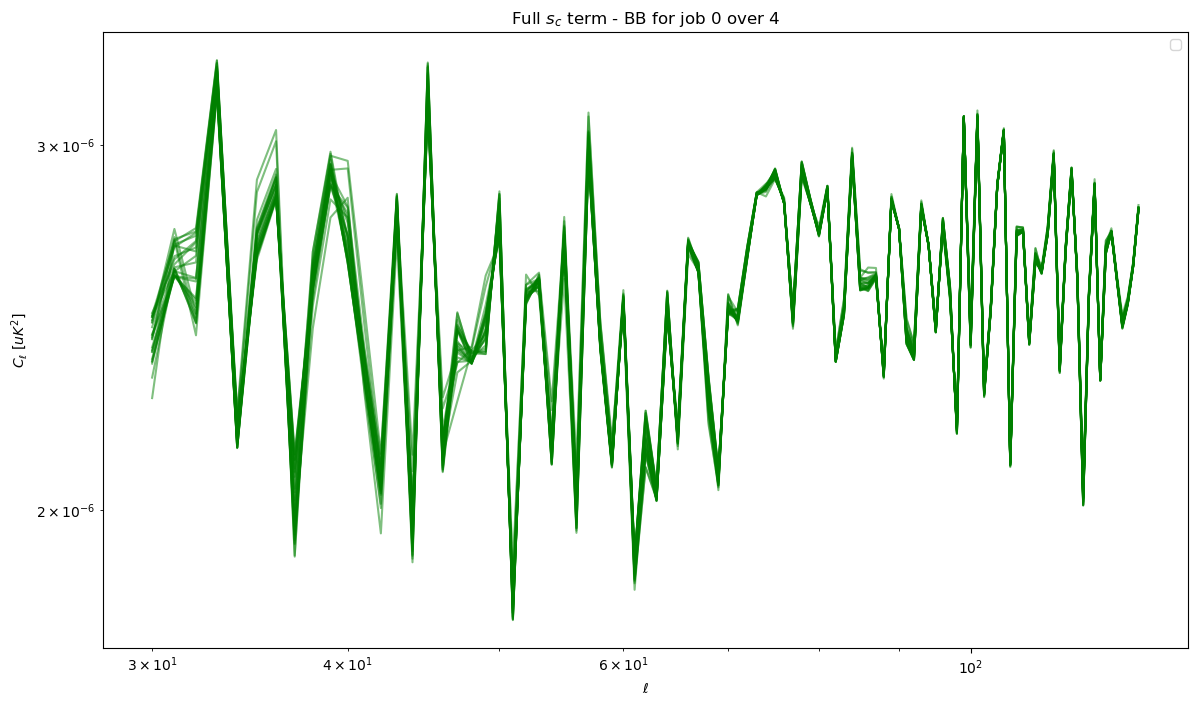

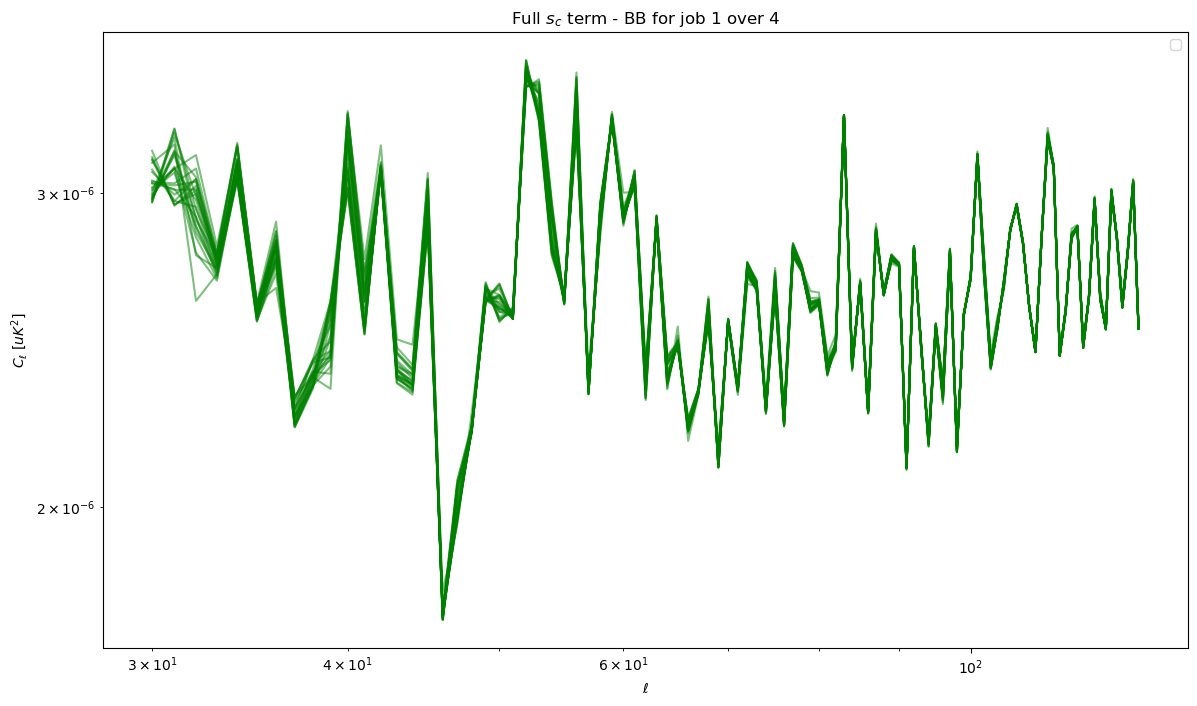

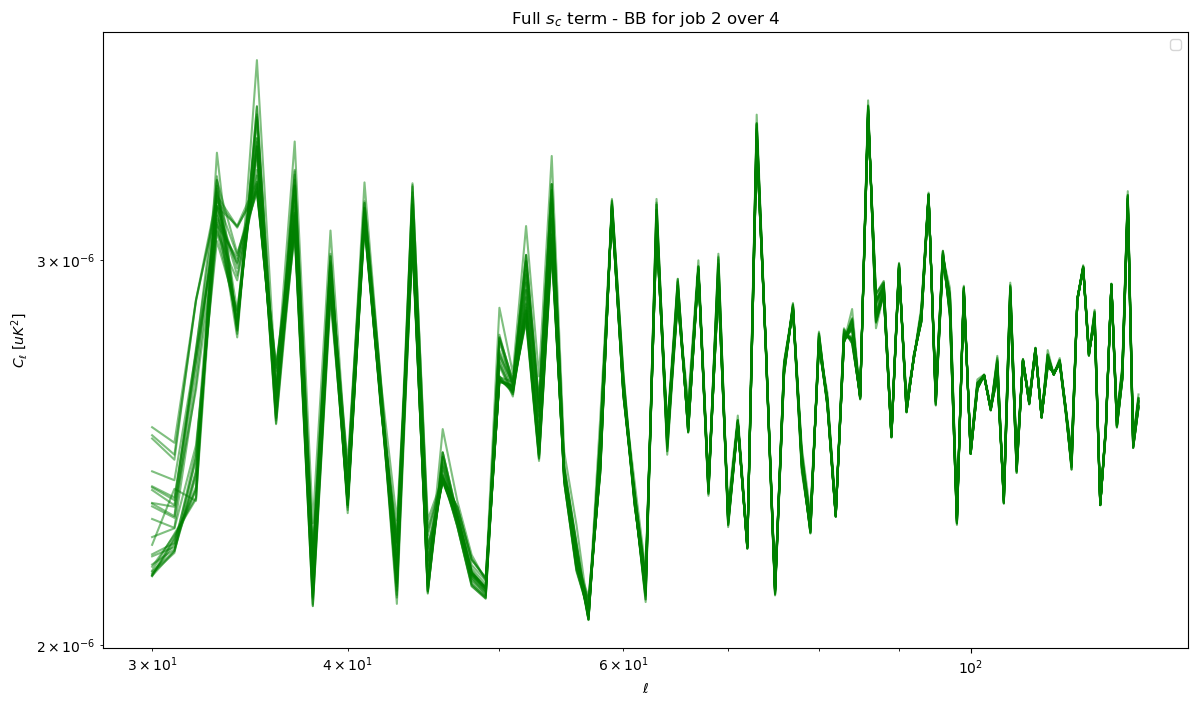

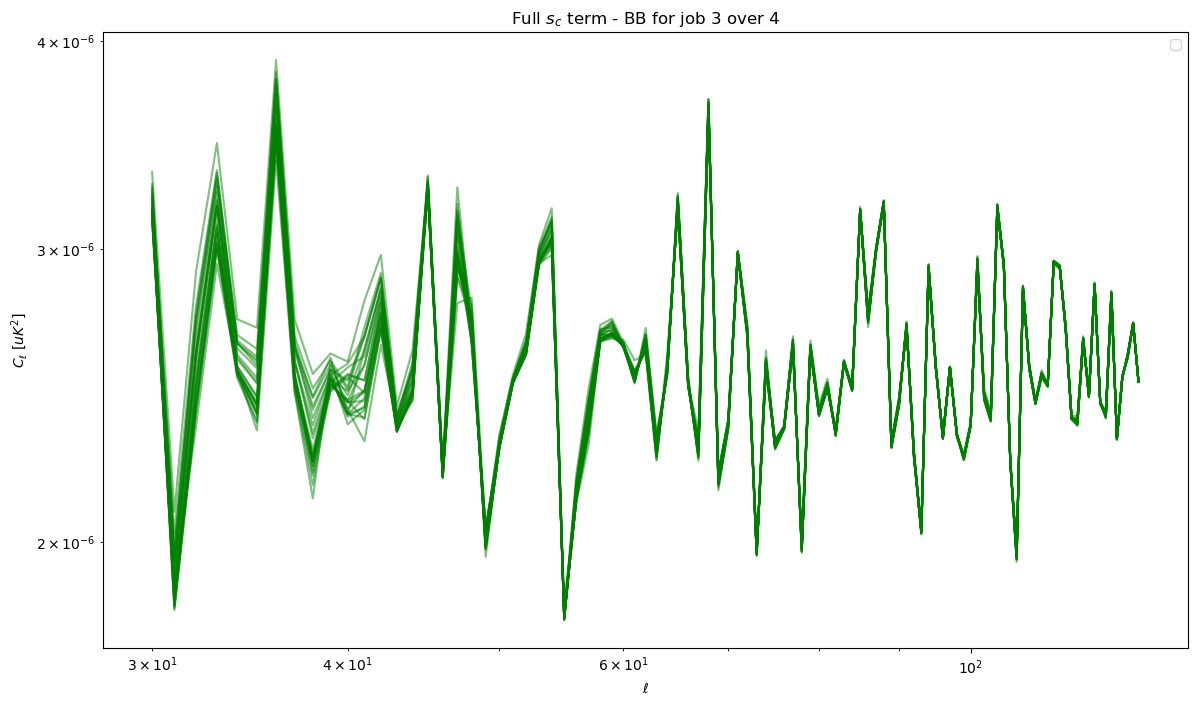

In [72]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']
# overrelaxation_param = -.89

# map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
# c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar, MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + MICMAC_sampler_obj.lmin

for job in range(num_jobs):
    plt.figure(figsize=(14,8))
    for iteration in range(0,MICMAC_sampler_obj.number_iterations_sampling,sub_step_sampling):
        covariance_noise = np.zeros_like(c_ell_approx)

        # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration,...])[MICMAC_sampler_obj.lmin:]
        mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration])
        if iteration != 0:
            # red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(all_cell_samples[iteration-1,...])[MICMAC_sampler_obj.lmin:]
            mixing_matrix_obj.update_params(all_params_mixing_matrix_samples[job,iteration-1])
        mixing_matrix_sampled = mixing_matrix_obj.get_B()
        BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
        BtinvN_sqrt = micmac.get_BtinvN(sp.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
        BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)
        s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, initial_freq_maps[job], jax_use=False)[0, :, :]

        # full_map_s_c = all_s_c_WF_maps[iteration] + all_s_c_fluct_maps[iteration]
        full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
        c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

        plt.plot(np.arange(c_ell_s_cML.shape[-1])+lmin, c_ell_s_cML[1,:], 'g', alpha=.5)

    plt.title(f"Full $s_c$ term - {list_correl[1]} for job {job} over {num_jobs}")
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.loglog()
    plt.legend()


plt.show()

# Plot $C$

In [73]:
if MICMAC_sampler_obj.sample_C_inv_Wishart and not(np.isnan(all_cell_samples).any()):
    job_index = 0
    nstokes_select = 1
    ell_select = 0
    burnin = 0
    selection = all_cell_samples[job_index,burnin:,nstokes_select,ell_select]

    n_sigma = 3
    transformed_samples = np.abs(selection - selection.mean())/(selection.std()) #< n_sigma
    cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
    mean_r = np.round(selection[cond].mean(), decimals=5)
    std_r = np.round(selection[cond].std(), decimals=5)

    # hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins='rice')
    hist_nb, hist_values, _ = plt.hist(selection, range=(selection.min()*0.8,selection.max()*1.1), bins=1000)
    plt.plot([c_ell_true_CMB[nstokes_select,ell_select],c_ell_true_CMB[nstokes_select,ell_select]], [0,hist_nb.max()], 'r--', label='True CMB')
    plt.plot([selection.mean(),selection.mean()], [0,hist_nb.max()], '--', color='darkseagreen', label='Mean sample')
    plt.xscale('log')
    # (all_cell_samples
    plt.legend()
    plt.show()

In [74]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    any_nan = np.argwhere(np.isnan(all_cell_samples[job_index]))

    print("First nan appear :", any_nan[:MICMAC_sampler_obj.nstokes+1])

In [75]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    ell_to_probe = 10 #0
    correl = 1

    plt.figure(figsize=(14,5))
    true_CMB_ell = c_ell_true_CMB[correl,ell_to_probe]#*(2*(ell_to_probe+MICMAC_sampler_obj.lmin)+1)#**2

    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1)+1, all_cell_samples[job_index,:,correl,ell_to_probe])
    plt.plot([-1,MICMAC_sampler_obj.number_iterations_sampling+1], [true_CMB_ell,true_CMB_ell], label='True CMB')

    plt.xlabel("Iteration")
    plt.ylabel(r"$C_\ell$ [$uK^2$]")
    plt.loglog()
    # plt.ylim(ymin=0.00015, ymax=0.00017)
    plt.legend()
    plt.show()


In [76]:
input_cmb_maps.shape

(4, 6, 2, 49152)

In [77]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    plt.plot(ell_arange, all_cell_samples[job_index,721].T)
    plt.loglog()
    plt.show()

In [78]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    job_index = 0
    plt.plot(ell_arange[75:85], all_cell_samples[job_index,722,:,75:85].T)

    # plt.loglog()
    plt.yscale('log')
    plt.show()

In [79]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    for job in range(num_jobs):
        input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[job,0,0]),input_cmb_maps[job,0]])
        cmb_anafast = hp.anafast(input_cmb_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

        dict_color = {'fill': 'moccasin', 'border': 'orange'}
        dict_color_theoretical = {'fill': 'lightcoral', 'border': 'tab:red'}
        # curve_theoretical = cmb_anafast
        # std_theoretical = cmb_anafast*np.sqrt(2/(2*ell_arange+1))# Knox cosmic covariance
        c_ell_mean = np.mean(all_cell_samples[job], axis=0)
        # c_ell_mean = np.mean(all_cell_samples[500:], axis=0)
        # c_ell_mean = np.mean(all_cell_samples[-2:], axis=0)

        list_correl = ['EE', 'BB', 'EB']

        ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
        factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
        factor[0] = 1
        # factor_ell = ((2*ell_arange+1)/(2*ell_arange+1 - 2 - 2))
        # factor = ell_arange*(ell_arange+1)/(2*np.pi)
        plt.figure(figsize=(15,10))
        for j in range(number_correl_to_plot):
            plt.subplot(311+j)
            plt.title(list_correl[j])
            if j > MICMAC_sampler_obj.nstokes-1:
                plt.title(list_correl[j] + ' with incorrect ell=2 !')

            curve_theoretical = cmb_anafast[j]
            std_theoretical = cmb_anafast[j]*np.sqrt(2/(2*ell_arange+1))
            plt.plot(ell_arange, curve_theoretical, color=dict_color_theoretical['border'], label='Anafast CMB $\pm$ Knox')
            plt.fill_between(ell_arange, curve_theoretical-std_theoretical, curve_theoretical+std_theoretical, color=dict_color_theoretical['fill'], alpha=0.2)
            plt.plot(ell_arange, curve_theoretical-std_theoretical, color=dict_color_theoretical['border'], alpha=0.6)
            plt.plot(ell_arange, curve_theoretical+std_theoretical, color=dict_color_theoretical['border'], alpha=0.6)

            plt.plot(ell_arange, c_ell_mean[j]/factor, '--', color=dict_color['border'], label='Mean value samples C')
            
            curve = c_ell_mean[j]
            std_curve = np.std(all_cell_samples[job,:,j,...], axis=0)

            plt.fill_between(ell_arange, (curve-std_curve)/factor, (curve+std_curve)/factor, color=dict_color['fill'], alpha=0.2)
            plt.plot(ell_arange, (curve-std_curve)/factor, color=dict_color['border'], alpha=0.6)
            plt.plot(ell_arange, (curve+std_curve)/factor, color=dict_color['border'], alpha=0.6)
            plt.plot(ell_arange, c_ell_true_CMB[j], color='tab:blue', label='True CMB')

            if j < MICMAC_sampler_obj.nstokes:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.loglog()
            plt.legend()
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
    plt.show()

In [80]:
if MICMAC_sampler_obj.sample_C_inv_Wishart:
    for job in range(num_jobs):
        dict_color = {'fill': 'moccasin', 'border': 'orange'}

        list_correl = ['EE', 'BB', 'EB']

        ell_arange = np.arange(c_ell_mean.shape[1]) + MICMAC_sampler_obj.lmin
        # factor = (2*ell_arange+1)/(2*ell_arange+1 - 2 - 2*MICMAC_sampler_obj.nstokes)
        plt.figure(figsize=(15,10))
        for j in range(number_correl_to_plot):
            plt.subplot(311+j)
            plt.title(list_correl[j])

            plt.plot(ell_arange, c_ell_true_CMB[j], label='True CMB')
            for ell in range(c_ell_mean.shape[1]):
                plt.plot(ell_arange[ell]*np.ones(MICMAC_sampler_obj.number_iterations_sampling+1), all_cell_samples[job,:,j,ell], '.', color=dict_color['border'], alpha=0.1)
            # plt.plot(ell_arange, all_cell_samples[:,j,:].T, '.', color=dict_color['border'], label='Mean value samples C')

            if j < MICMAC_sampler_obj.nstokes:
                plt.loglog()
            else:
                plt.xscale('log')
                plt.yscale('symlog')
            # plt.loglog()
            plt.legend()
            plt.ylabel("$C_\ell$ [$uK^2$]")
            plt.xlabel(r"$\ell$")
    plt.show()

# Studying $r$

(2396,) 2400
(2397,) 2400
(2398,) 2400
(2385,) 2400


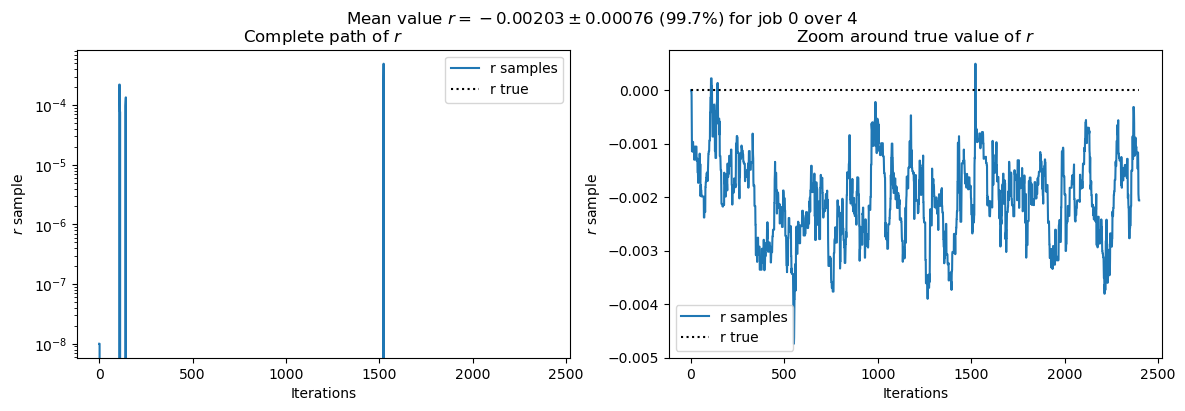

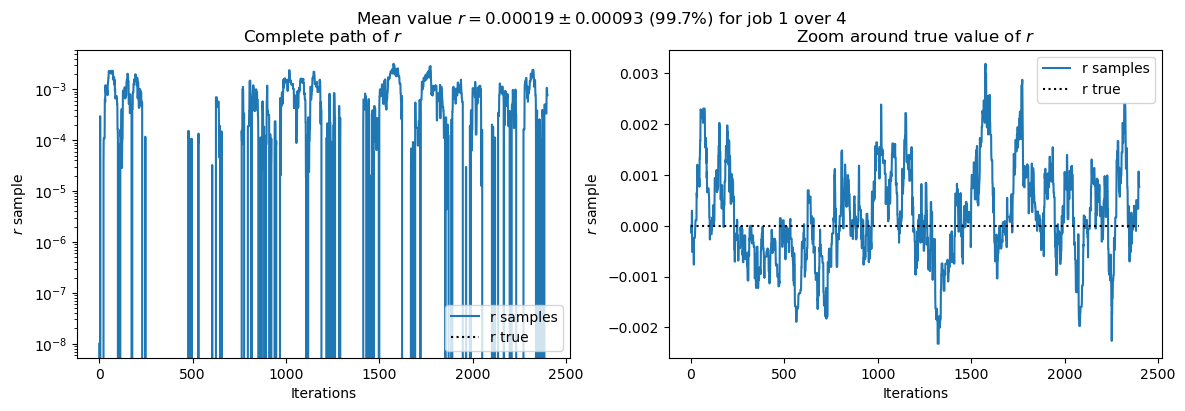

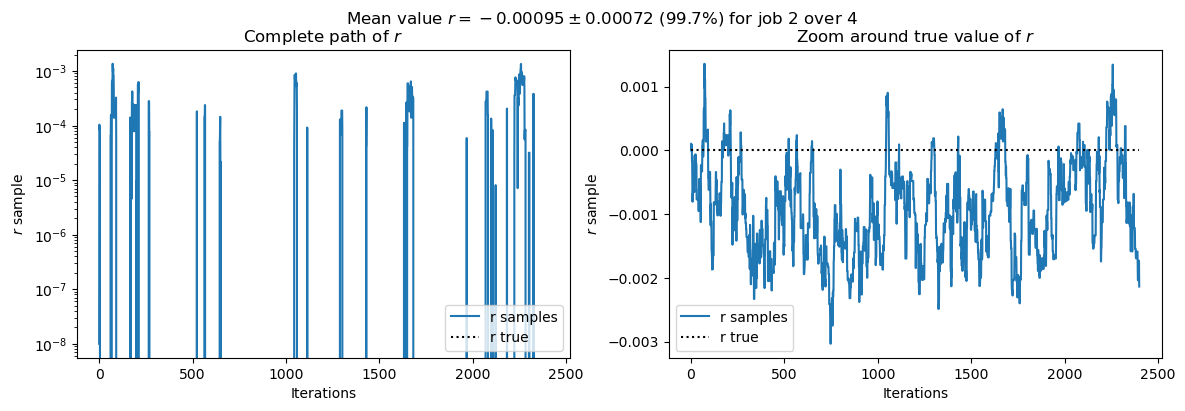

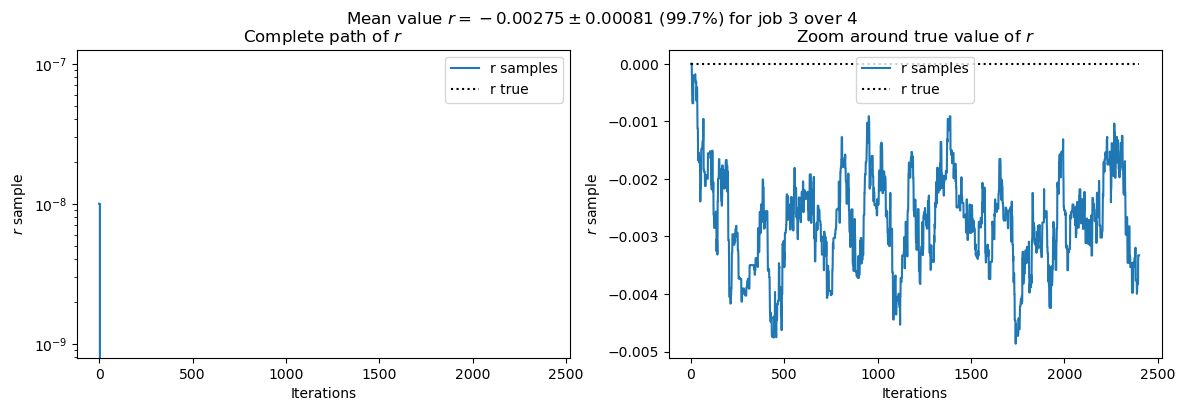

In [81]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        plt.figure(figsize=(14,4))
        
        n_sigma = 3
        
        cond = np.abs((all_r_samples[job] - all_r_samples[job].mean())/(all_r_samples[job].std())) < n_sigma
        print(all_r_samples[job,cond].shape, MICMAC_sampler_obj.number_iterations_sampling)
        mean_r = np.round(all_r_samples[job,cond].mean(), decimals=5)
        std_r = np.round(all_r_samples[job,cond].std(), decimals=5)
        
        
        plt.suptitle(f"Mean value $r = {mean_r} \pm {std_r}$ (99.7%) for job {job} over {num_jobs}")
        plt.subplot(121)
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples[job], label='r samples')
        plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
        if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
            plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [all_r_samples[job].min(),all_r_samples[job].max()], color='black',alpha=.2)
        plt.yscale('log')
        plt.xlabel("Iterations")
        plt.ylabel('$r$ sample')
        plt.title('Complete path of $r$')
        plt.legend()

        plt.subplot(122)
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_r_samples[job], label='r samples')
        plt.plot([0, MICMAC_sampler_obj.number_iterations_sampling+1], [MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], 'k:', label='r true')
        if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
            plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [all_r_samples[job].min(),all_r_samples[job].max()], '--', color='black')
        plt.xlabel("Iterations")
        plt.ylabel('$r$ sample')
        plt.title('Zoom around true value of $r$')
        plt.legend()
        # plt.ylim(ymin=MICMAC_sampler_obj.r_true*.7, ymax=MICMAC_sampler_obj.r_true*1.3)
    plt.show()

In [82]:
# all_r_samples[2000:].mean(), all_r_samples[2000:].std()

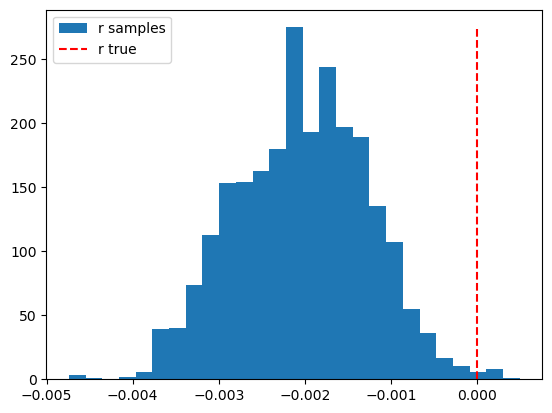

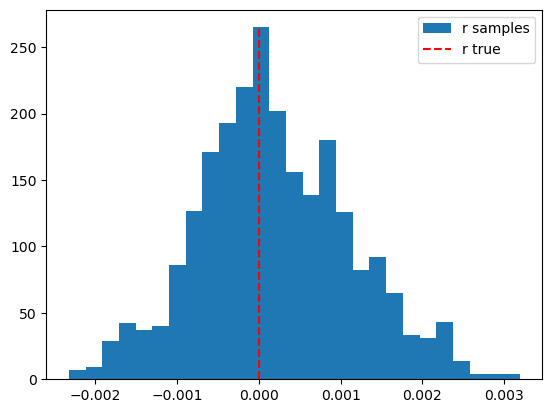

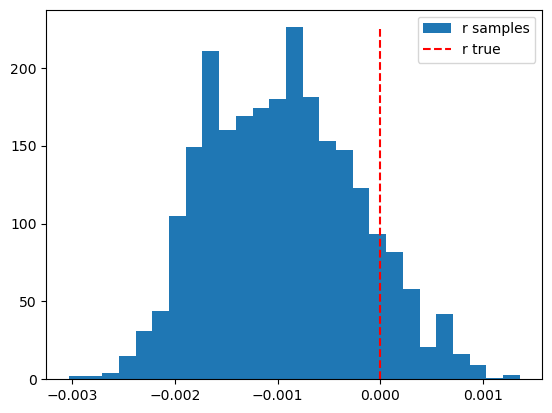

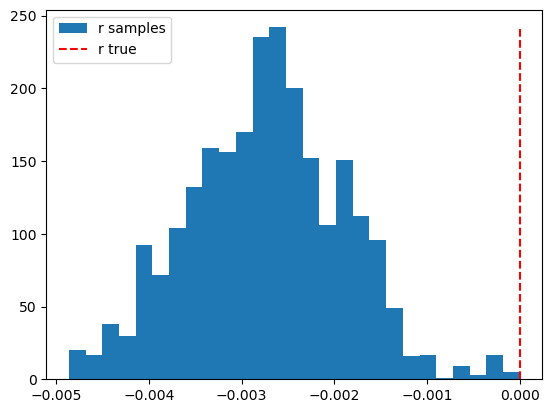

In [83]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        plt.figure()
        hist_values, bins_value, _ = plt.hist(all_r_samples[job], bins='rice', label='r samples')
        plt.plot([MICMAC_sampler_obj.r_true,MICMAC_sampler_obj.r_true], [0,hist_values.max()], 'r--', label='r true')
        plt.legend()
    plt.show()

In [84]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        
        n_sigma = 3

        old_cond = np.abs((all_r_samples[job] - all_r_samples[job].mean())/(all_r_samples[job].std())) < n_sigma
        new_cond = np.logical_and(old_cond, np.arange(MICMAC_sampler_obj.number_iterations_sampling+1) > 1000)
        mean_r = np.round(all_r_samples[job,new_cond].mean(), decimals=5)
        std_r = np.round(all_r_samples[job,new_cond].std(), decimals=5)

        print("r estimates post burn-in: {} +/- {}".format(mean_r, std_r))

        # selection_2 = all_r_samples[np.arange(MICMAC_sampler_obj.number_iterations_sampling+1) > 6000]
        # mean_r_2 = np.round(selection_2.mean(), decimals=5)
        # std_r_2 = np.round(selection_2.std(), decimals=5)

        # print("r estimates post burn-in: {} +/- {}".format(mean_r_2, std_r_2))


r estimates post burn-in: -0.002 +/- 0.00071
r estimates post burn-in: 0.00037 +/- 0.00094
r estimates post burn-in: -0.00085 +/- 0.00072
r estimates post burn-in: -0.00274 +/- 0.00077


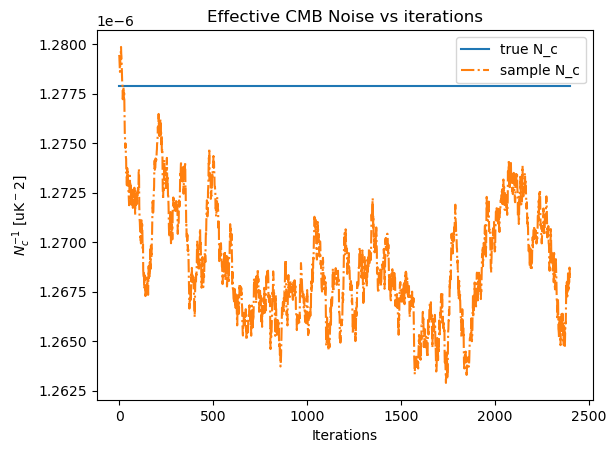

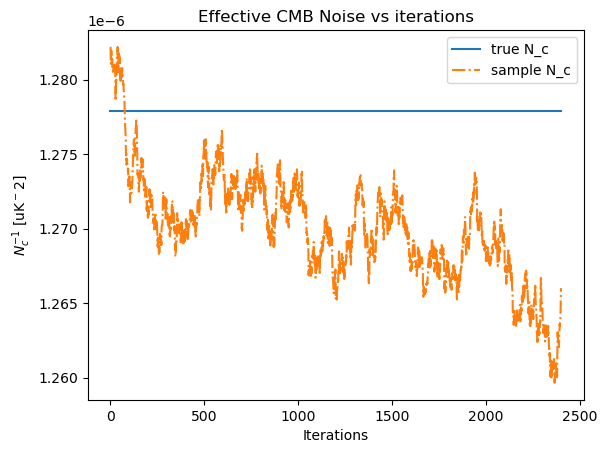

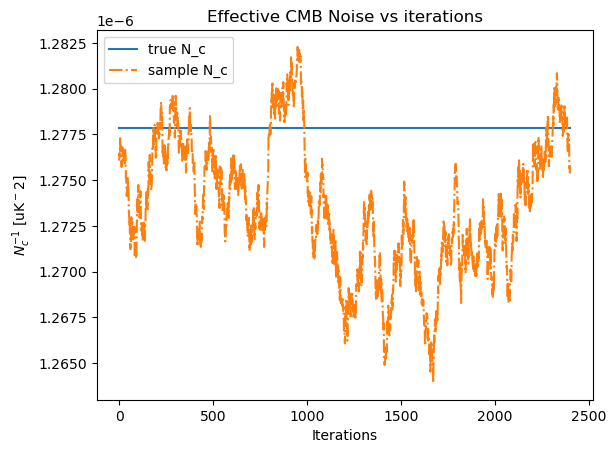

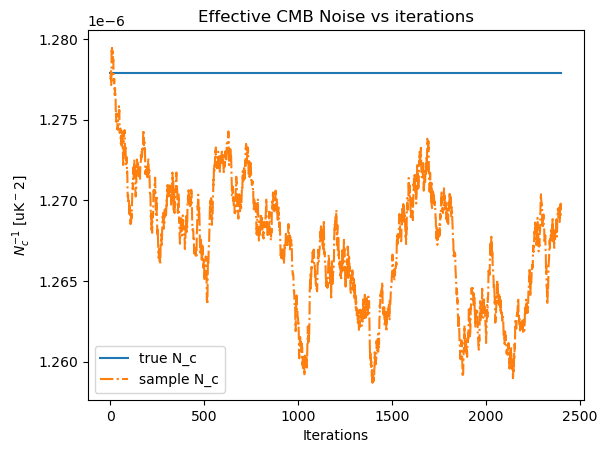

In [85]:
mixing_matrix_obj.update_params(init_params)
mixing_matrix_sampled = mixing_matrix_obj.get_B()
BtinvNB_true = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)

for job in range(num_jobs):
    all_mixing_matrix = np.zeros((MICMAC_sampler_obj.number_iterations_sampling+1,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_components))

    all_mixing_matrix[:,:,0] = mixing_matrix_sampled[:,0]
    all_mixing_matrix[:,0,:] = mixing_matrix_sampled[0,:]
    all_mixing_matrix[:,-1,:] = mixing_matrix_sampled[-1,:]

    all_mixing_matrix[:,1:-1,1:] = all_params_mixing_matrix_samples[job]


    true_N_c = BtinvNB_true[0,0]
    cl_noise_harm_0 = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin]
    all_inv_N_c = jnp.linalg.pinv(jnp.einsum("ifc,fh,ihd->icd", all_mixing_matrix, MICMAC_sampler_obj.freq_inverse_noise, all_mixing_matrix))[:,0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    plt.figure()
    plt.title('Effective CMB Noise vs iterations')
    # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [true_N_c,true_N_c], label='true N_c')
    plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [cl_noise_harm_0,cl_noise_harm_0], label='true N_c')
    plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_inv_N_c, '-.', label='sample N_c')

    plt.xlabel('Iterations')
    plt.ylabel('$N_c^{-1}$ [uK$^-2$]')
    # plt.loglog()
    # plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
plt.show()

In [86]:
# list_correl = ['EE', 'BB', 'EB']

# ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

# frequency_Bf = instrument['frequency'][1:-1]
# all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:,0]
# all_B_f_sample_dust = all_params_mixing_matrix_samples[:,:,1]

# frequency_array = np.array(instrument['frequency'])


# plt.figure(figsize=(14,4))
# plt.suptitle('Mixing matrix parameters sampled vs iterations')
# plt.subplot(121)
# plt.title(('Synch parameters'))
# for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
#     plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
# plt.legend()
# # plt.loglog()
# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('B_f params')

# plt.subplot(122)
# plt.title(('Dust parameters'))
# for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
#     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
#     plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
# plt.legend()
# # plt.loglog()
# plt.yscale('log')
# plt.xlabel('Iterations')
# plt.ylabel('B_f params')
# plt.show()


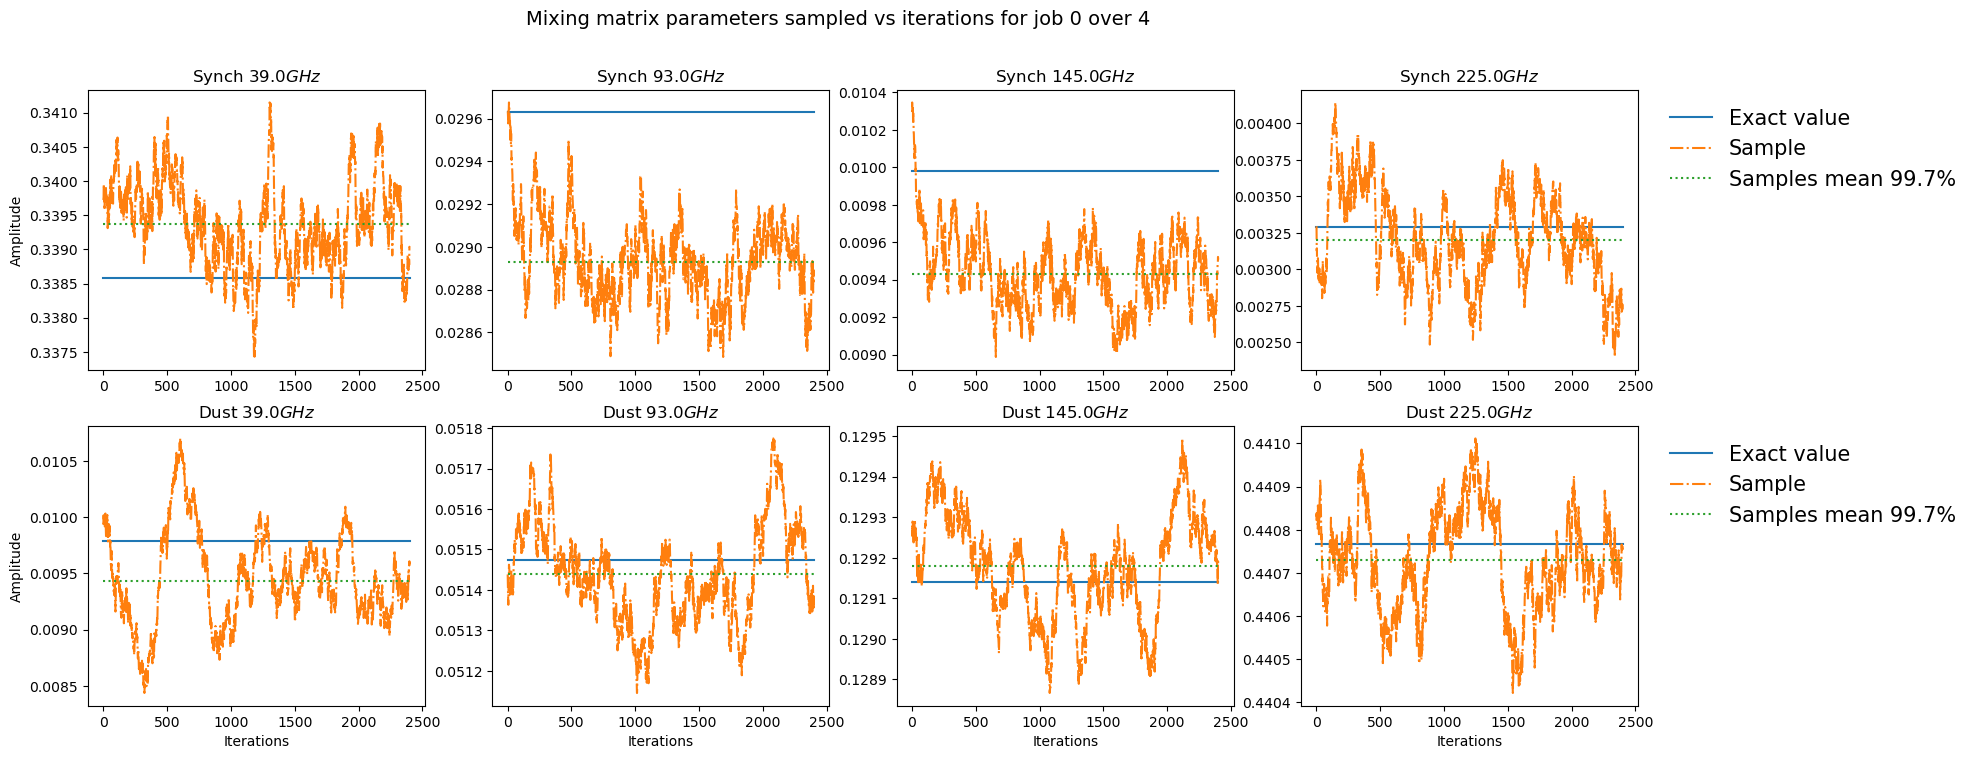

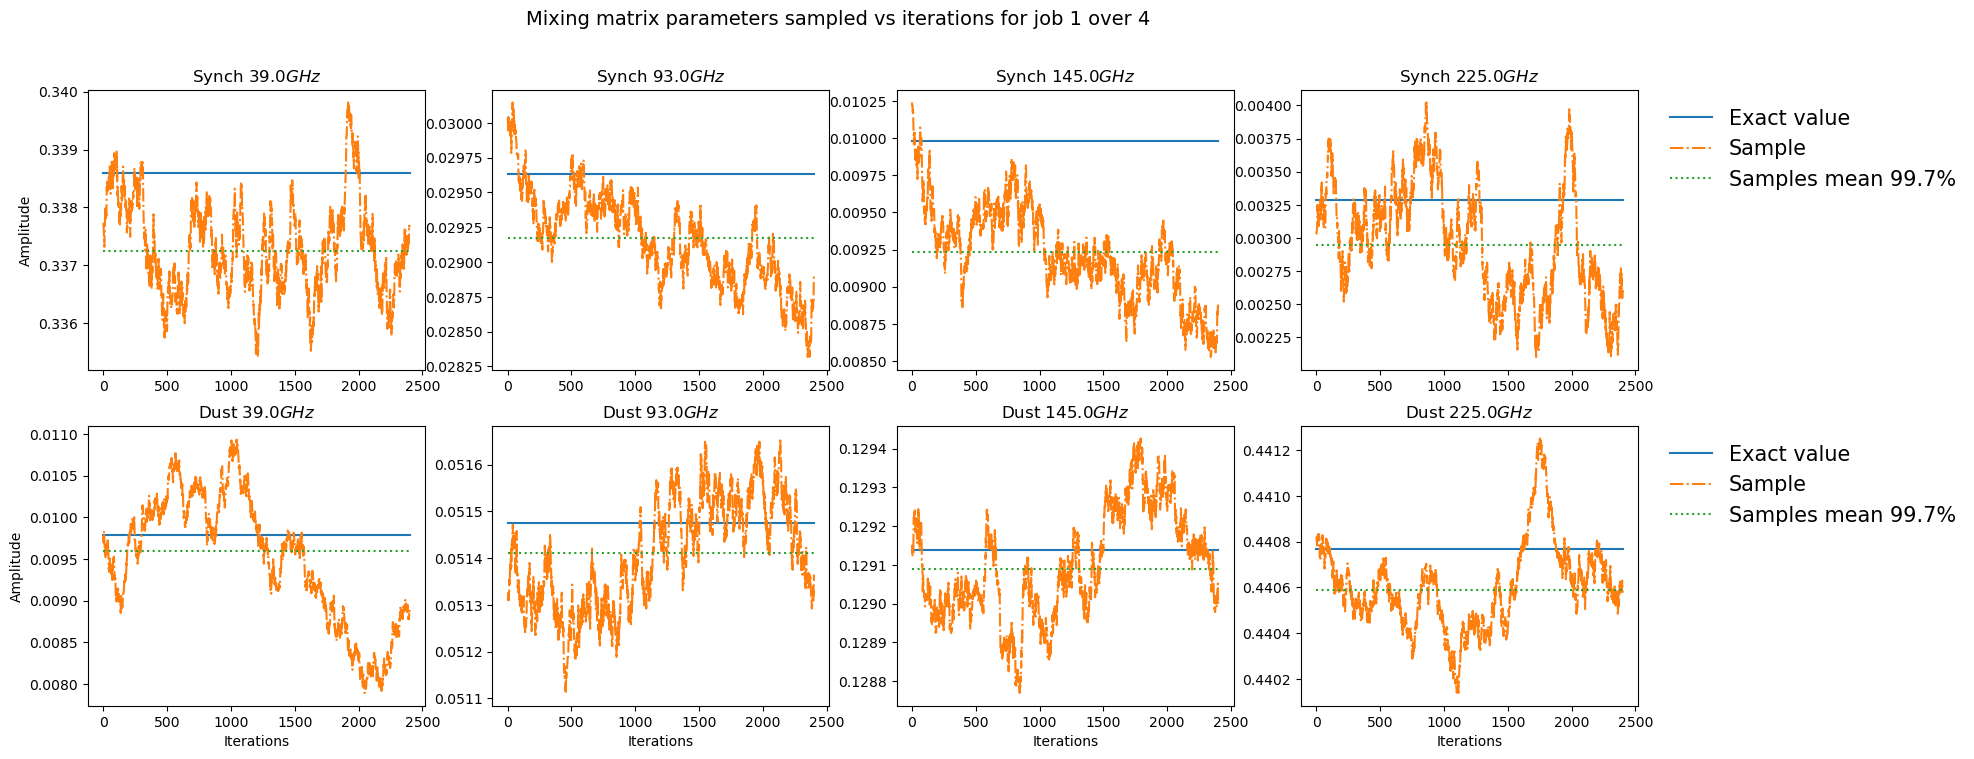

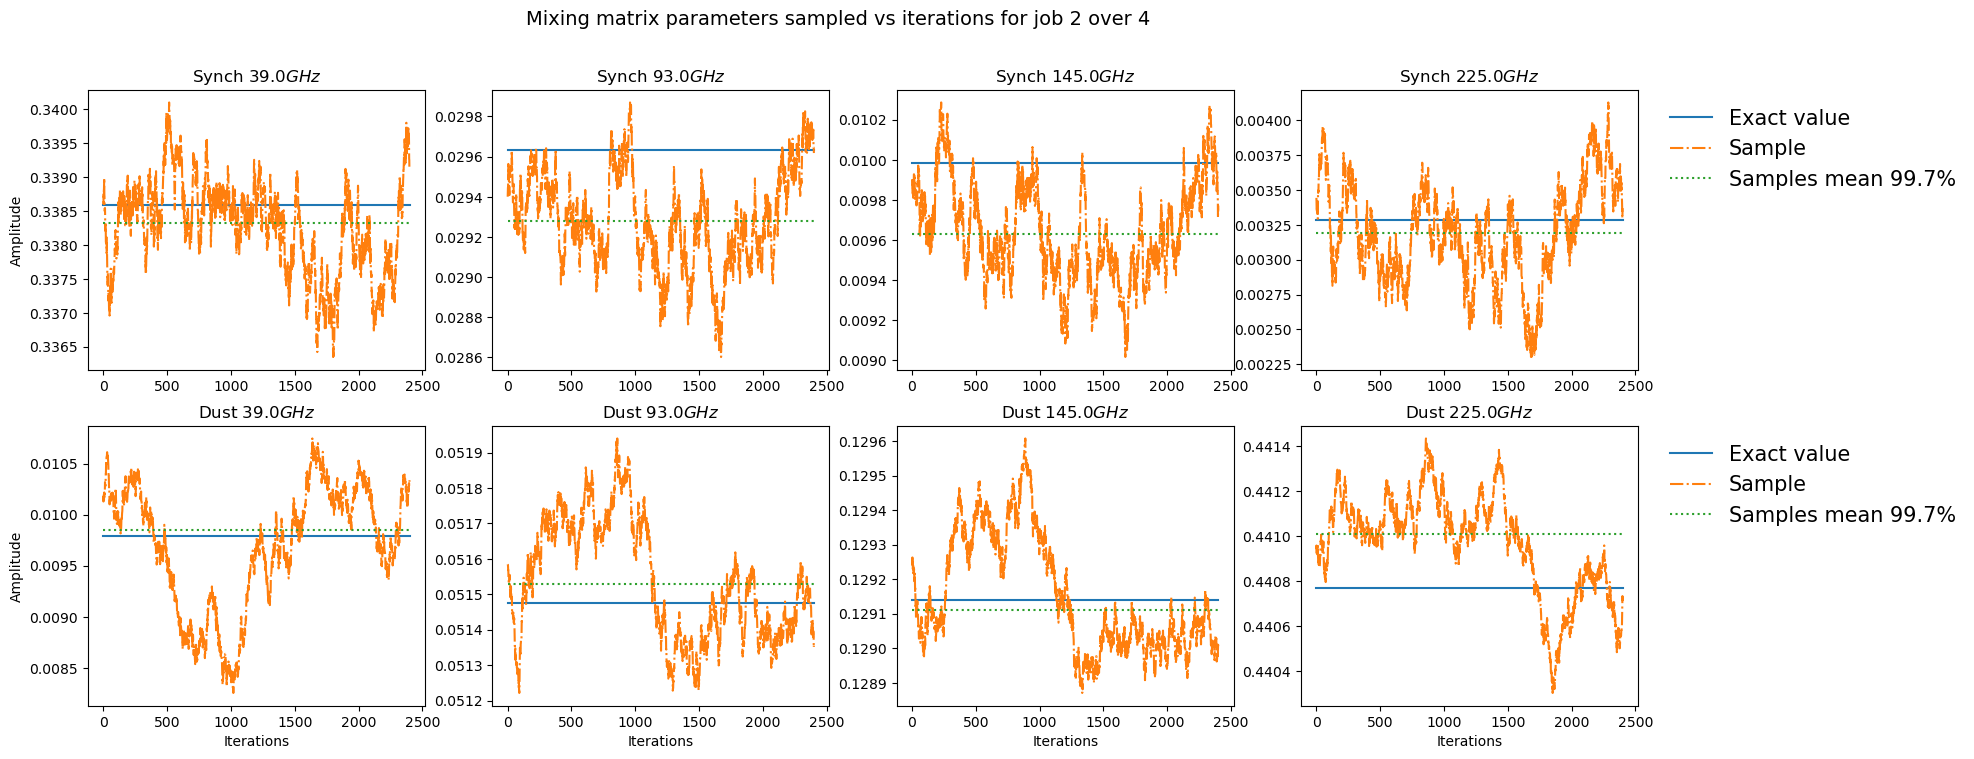

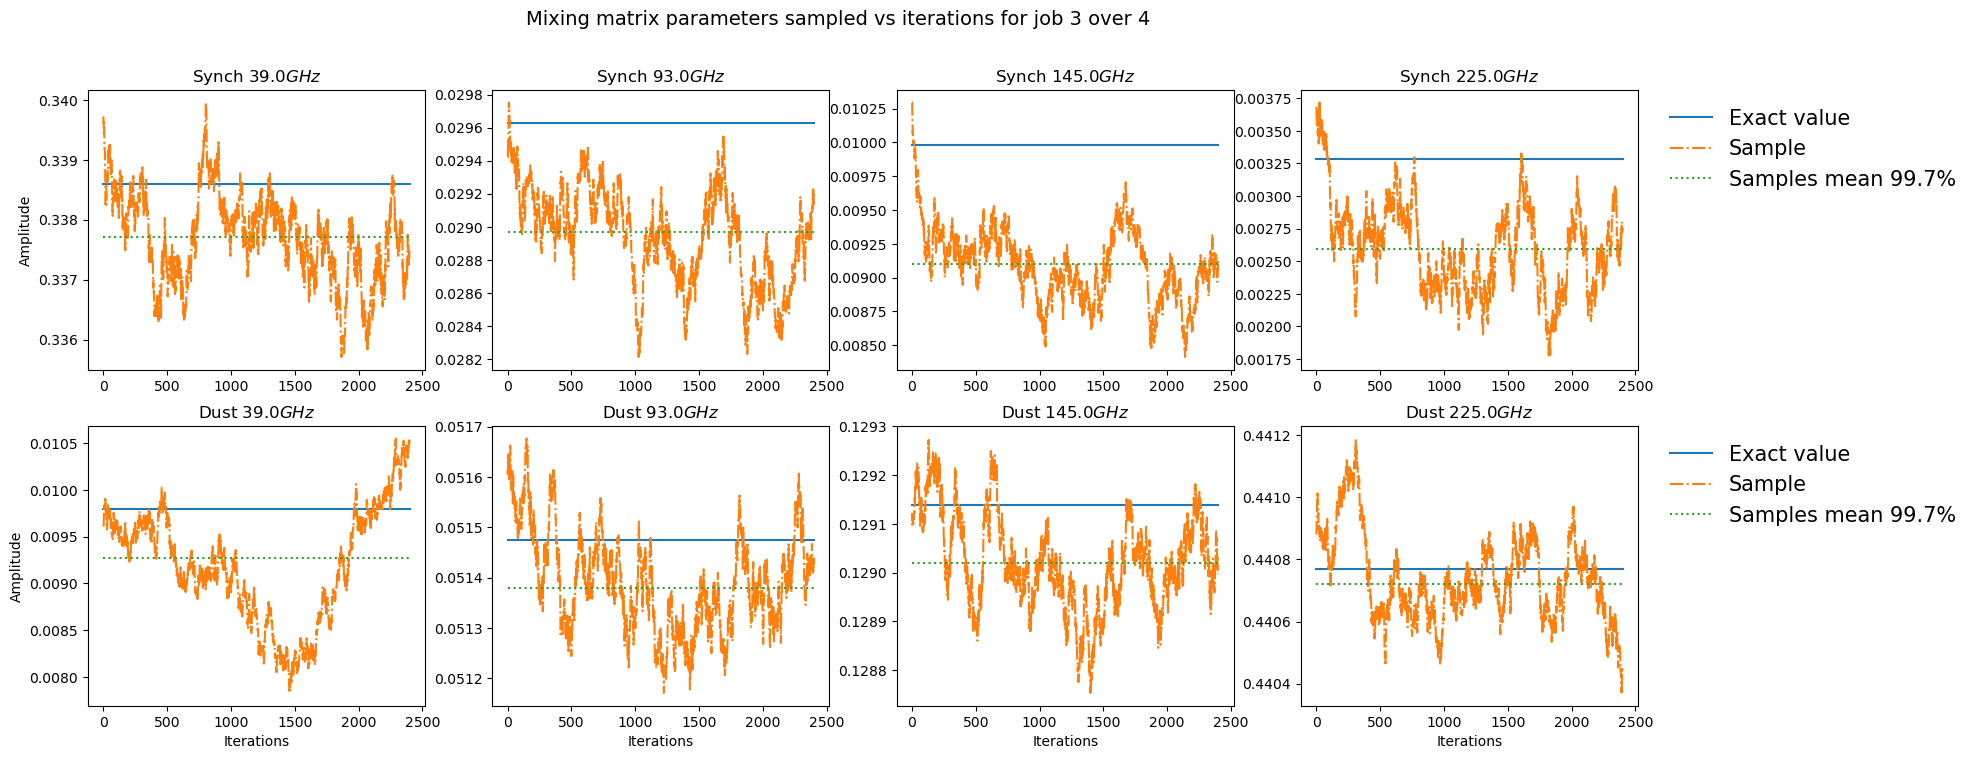

In [87]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

for job in range(num_jobs):
    all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:,0]
    all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,:,1]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs < 10:
        plt.figure(figsize=(20,8))
        plt.suptitle('Mixing matrix parameters sampled vs iterations for job {} over {}'.format(job,num_jobs), fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
            plt.subplot(201+len(frequency_Bf)*10+i)
            plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]], label='Exact value')
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
            
            n_sigma = 3
            transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
            cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_synch[:,i].mean()
            plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

            # plt.yscale('log')
            # plt.xlabel('Iterations')
            if i == 0:
                plt.ylabel('Amplitude')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
            plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
            plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]], label='Exact value')
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

            n_sigma = 3
            transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
            cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_dust[:,i].mean()
            plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
            # plt.yscale('log')
            plt.xlabel('Iterations')
            if i == 0:
                plt.ylabel('Amplitude')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

In [88]:
# useless_plots

In [89]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])

for job in range(num_jobs):
    all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:,0]
    all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,:,1]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs >= 10:
        number_columns = 4
        number_rows = (MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)//number_columns + 1

        # plt.figure(figsize=(20,8))
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        # plt.subplot(121)

        for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_synch[:,i], '-.', label='Sample')
            
            n_sigma = 3
            transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
            cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_synch[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

            # plt.yscale('log')
            # plt.xlabel('Iterations')
            ax[num_row, num_col].set_xlabel('Iterations')
            if i == 0:
                # plt.ylabel('Amplitude')
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])


        fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations for job {job} over {num_jobs}", fontsize=14)
        
        for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            num_row = i//number_columns
            num_col = i%number_columns
            ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]], label='Exact value')
            ax[num_row, num_col].plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_sample_dust[:,i], '-.', label='Sample')

            n_sigma = 3
            transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
            cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
            std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

            mean_value = all_B_f_sample_dust[:,i].mean()
            ax[num_row, num_col].plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
            # plt.yscale('log')
            
            if i == 0:
                ax[num_row, num_col].set_ylabel('Amplitude')
            if i >= MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs-number_columns:
                ax[num_row, num_col].set_xlabel('Iterations')
            else:
                ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()

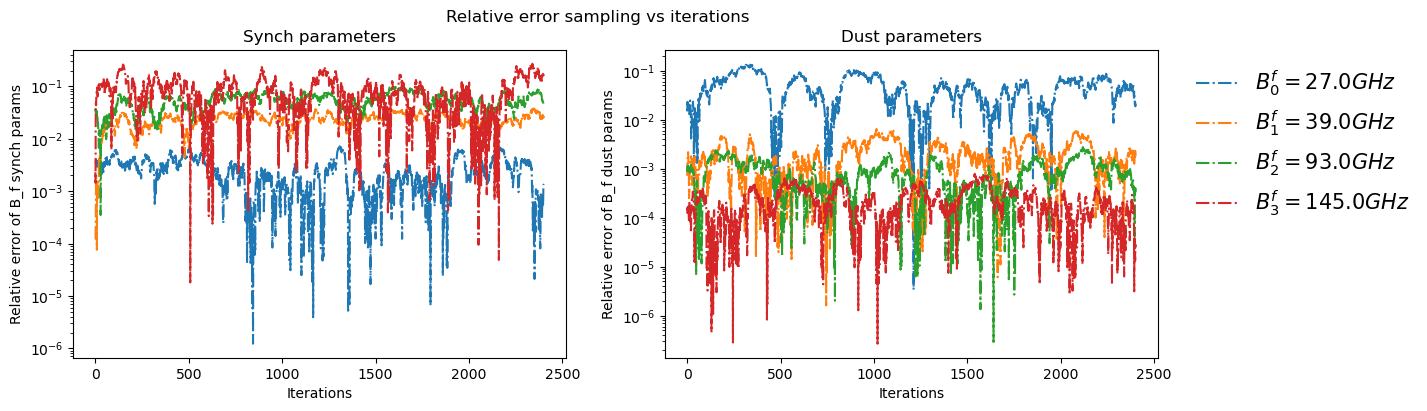

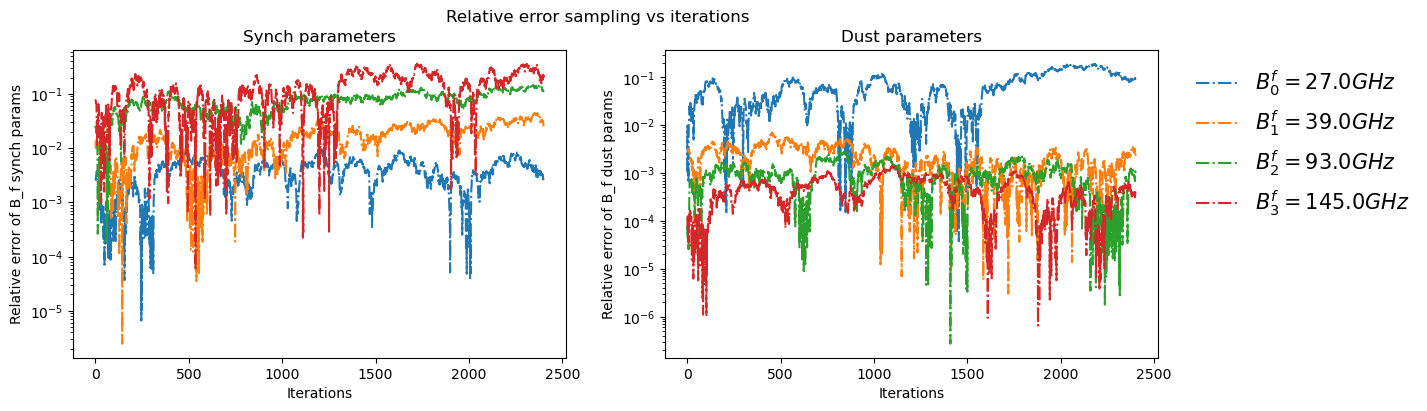

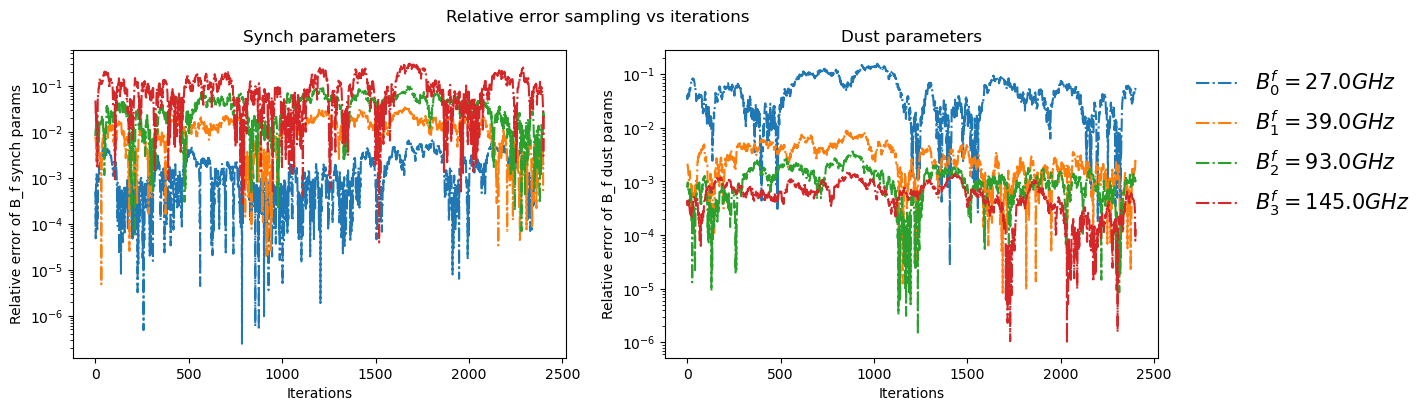

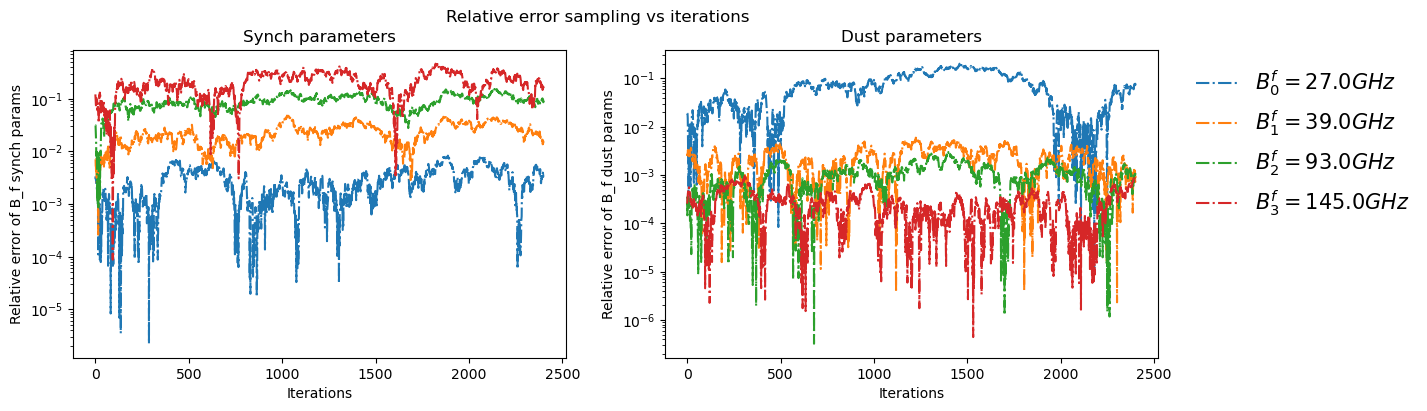

In [90]:
for job in range(num_jobs):
    all_B_f_sample_synch = all_params_mixing_matrix_samples[job,:,:,0]
    all_B_f_sample_dust = all_params_mixing_matrix_samples[job,:,:,1]

    plt.figure(figsize=(14,4))
    plt.suptitle('Relative error sampling vs iterations')
    plt.subplot(121)
    plt.title(('Synch parameters'))
    for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
        relative_error = np.abs((all_B_f_sample_synch[:,i]-init_params[i,0])/init_params[i,0])
    #     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]])
        # plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^s_{i}={frequency_array[i]} GHz$')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.')
    if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
        plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
    # plt.legend()
    plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Relative error of B_f synch params')

    plt.subplot(122)
    plt.title(('Dust parameters'))
    for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
        relative_error = np.abs((all_B_f_sample_dust[:,i]-init_params[i,1])/init_params[i,1])
    #     plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]])
        # plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f'$B^d_{i}={frequency_array[i]} GHz$')
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), relative_error, '-.', label=f"$B^f_{i}={frequency_array[i]} GHz$")
    if MICMAC_sampler_obj.num_sample_AM <= MICMAC_sampler_obj.number_iterations_sampling:
        plt.plot([MICMAC_sampler_obj.num_sample_AM,MICMAC_sampler_obj.num_sample_AM], [10**(-5),10**(-1)], '--', color='black')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

    plt.yscale('log')
    plt.xlabel('Iterations')
    plt.ylabel('Relative error of B_f dust params')
plt.show()


In [91]:
all_params_mixing_matrix_samples.shape

(4, 2401, 4, 2)

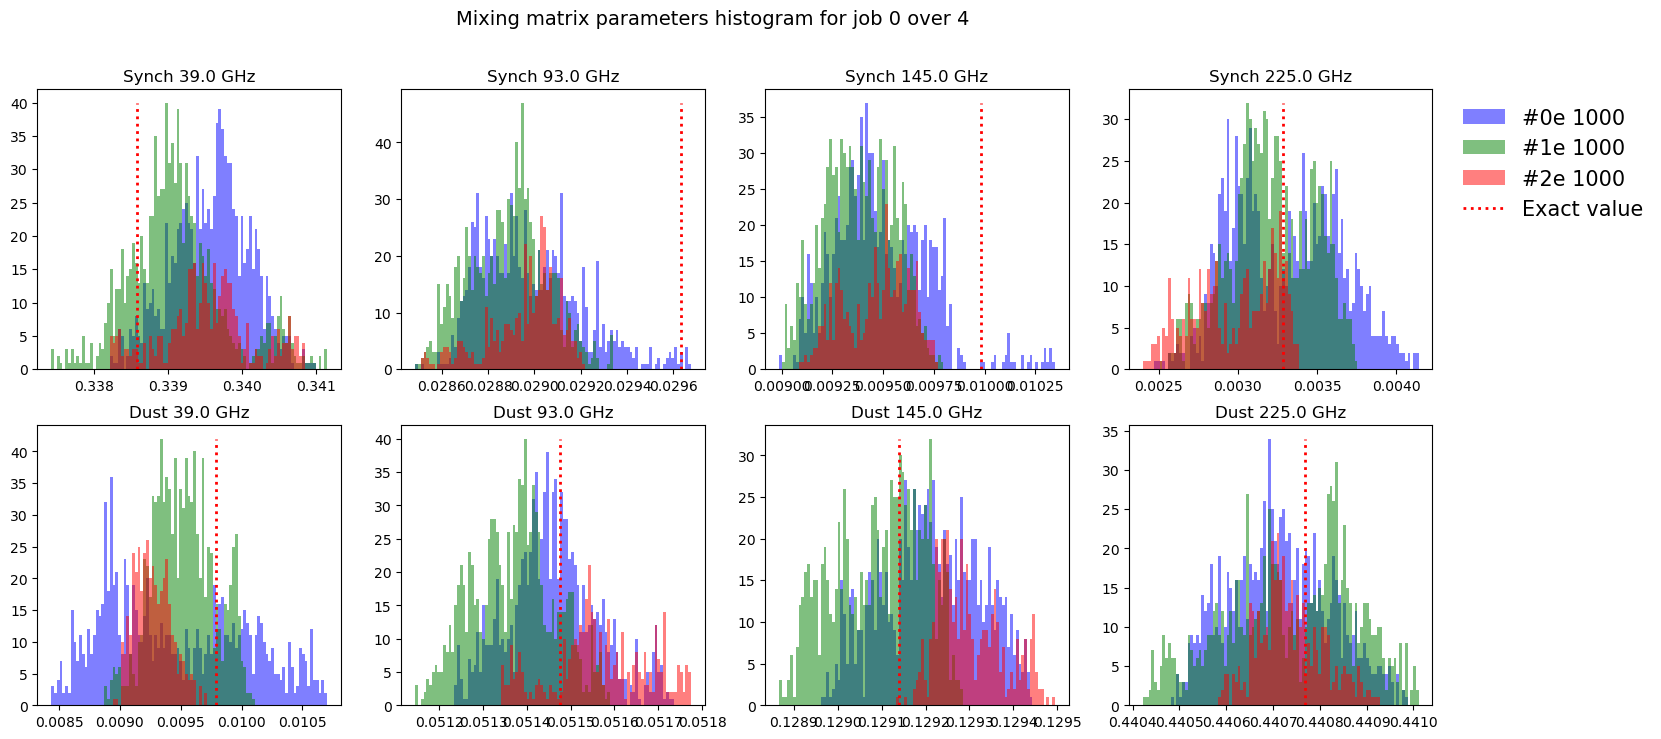

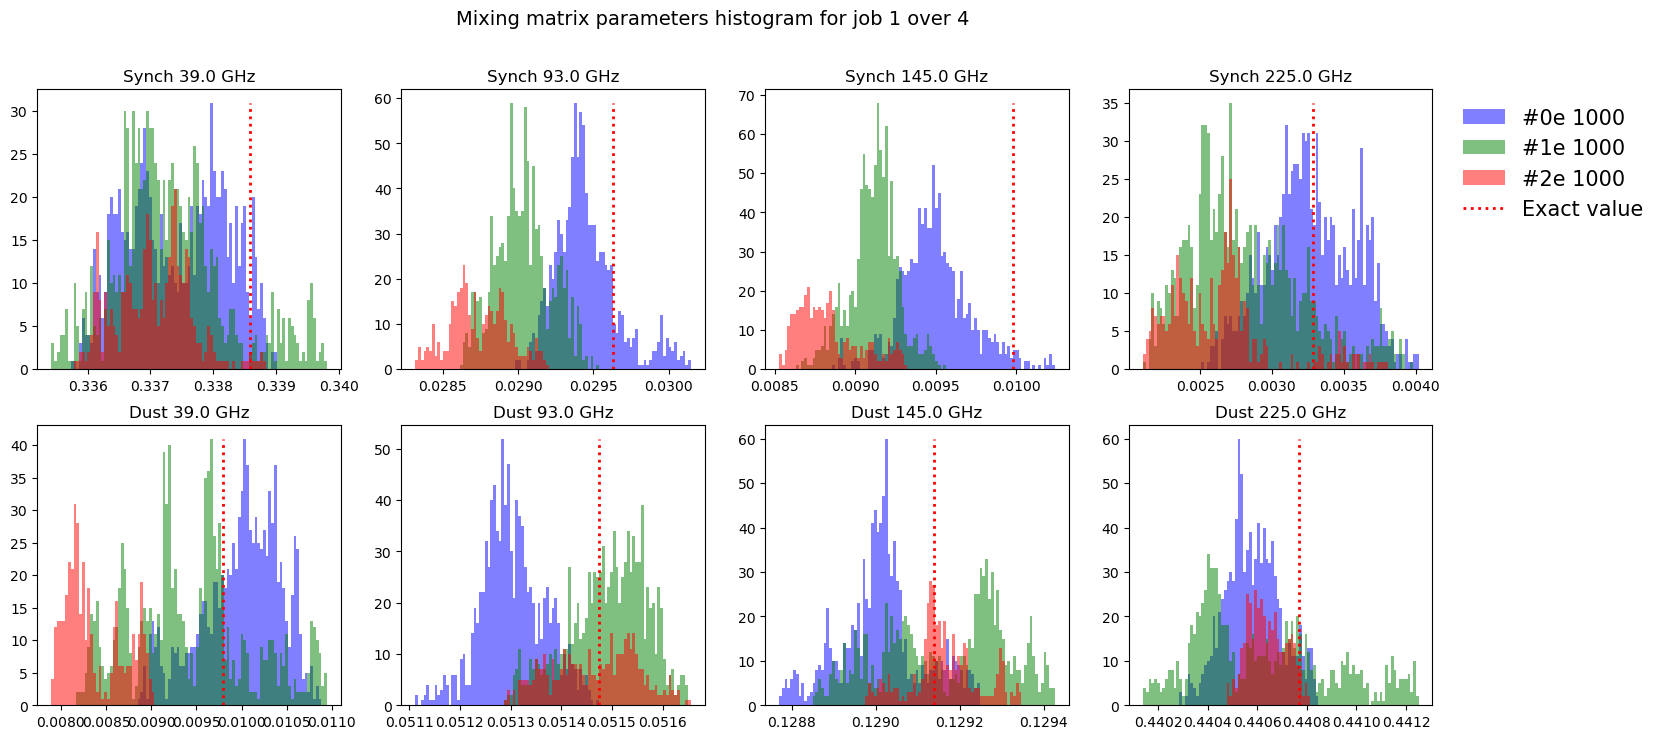

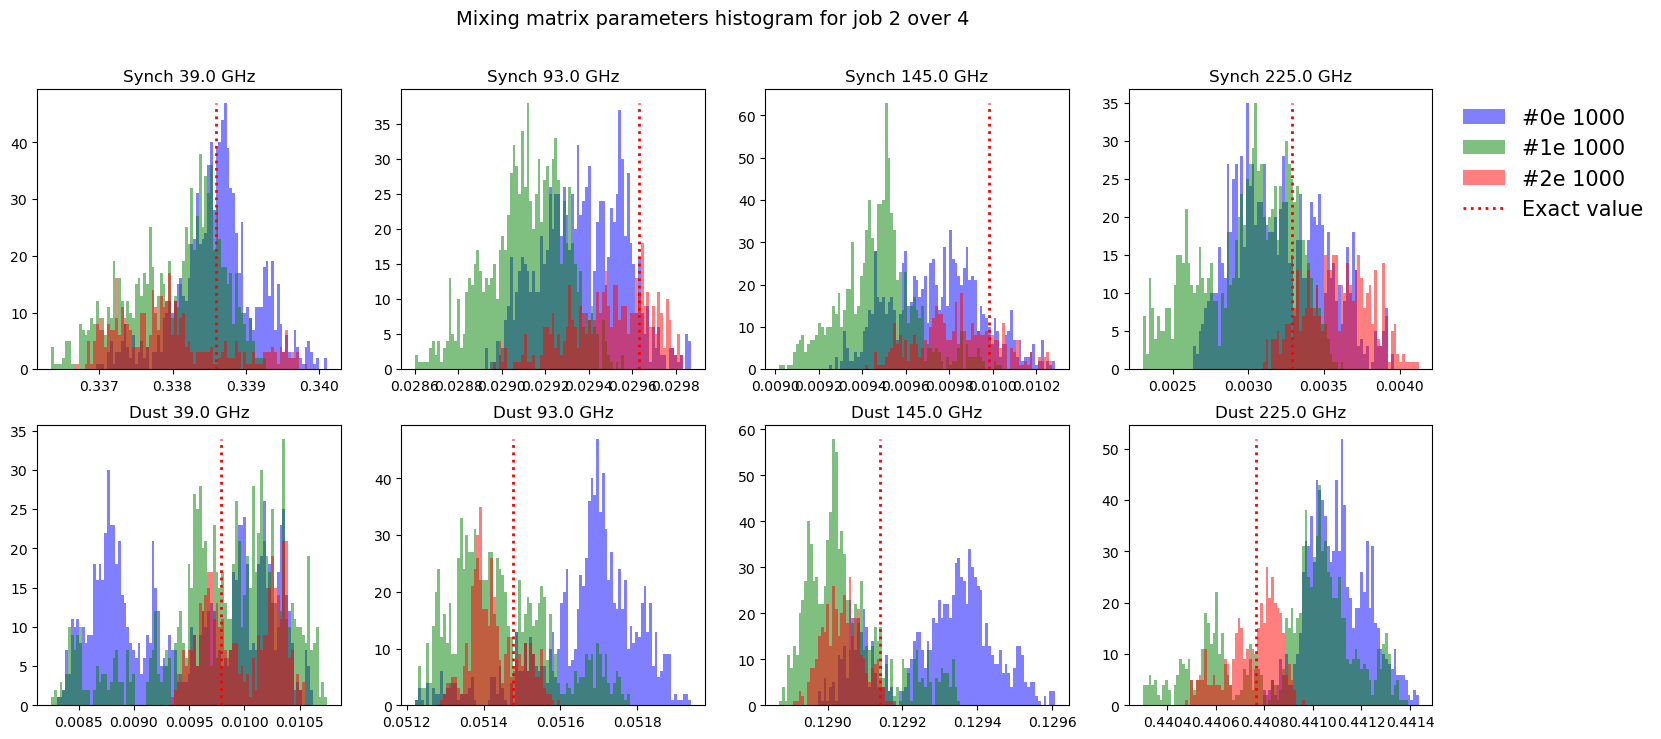

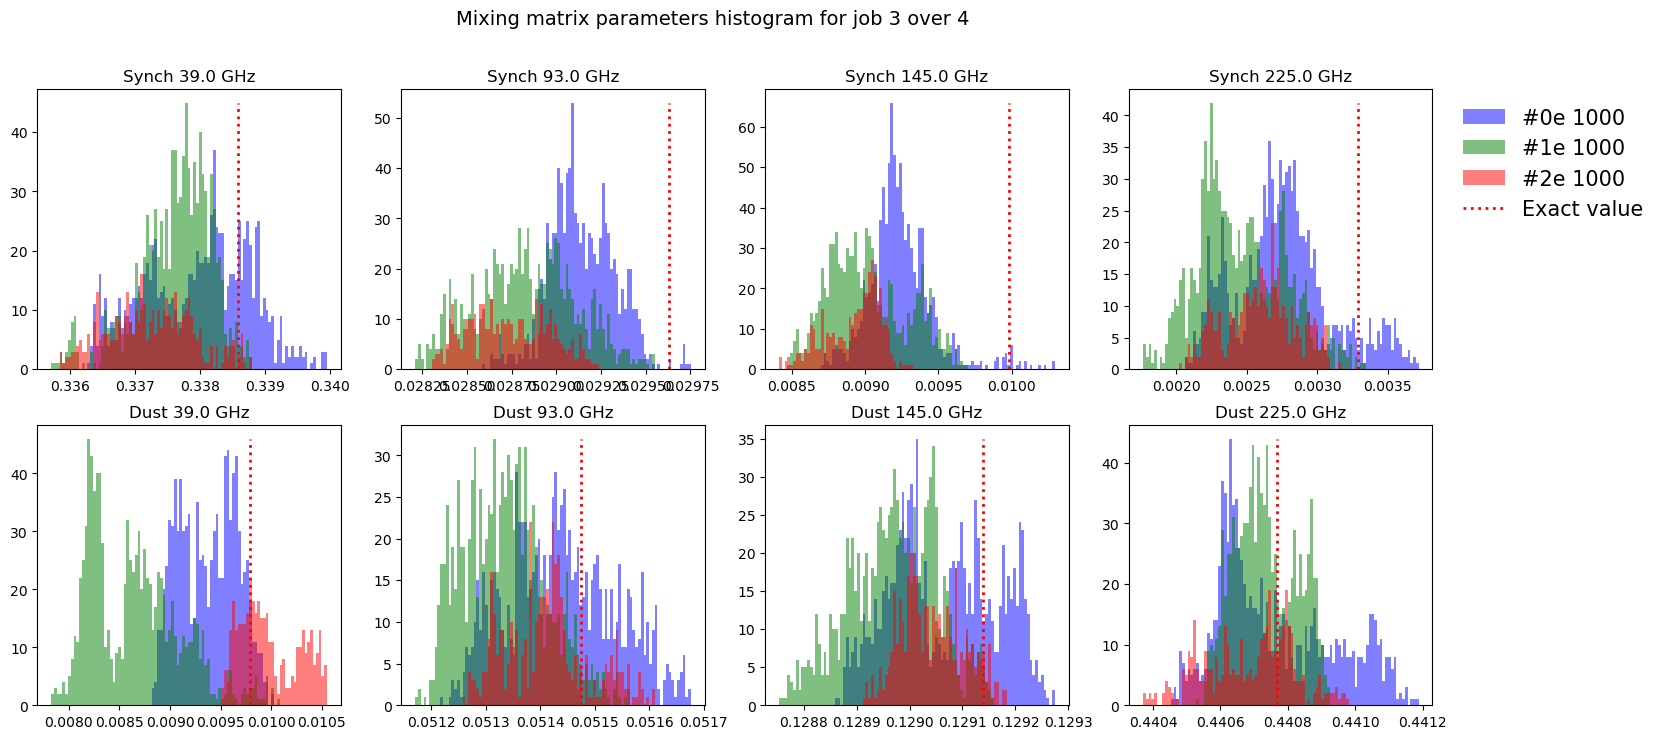

In [92]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']

for job in range(num_jobs):
    if MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs < 10:
        all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job]
        plt.figure(figsize=(18,8))
        plt.suptitle(f"Mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)

        for i in range(len(frequency_Bf)):
            plt.subplot(201+len(frequency_Bf)*10+i)
            plt.title((f'Synch {frequency_Bf[i]} GHz'))
            if all_params_mixing_matrix_samples_job[:,i,0].min() == all_params_mixing_matrix_samples_job[:,i,0].max():
                min_value = all_params_mixing_matrix_samples_job[:,i,0].min()*.9
                max_value = all_params_mixing_matrix_samples_job[:,i,0].max()*1.1
            else:
                min_value = all_params_mixing_matrix_samples_job[:,i,0].min()
                max_value = all_params_mixing_matrix_samples_job[:,i,0].max()
            bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

            max_height = 0
            for j in range(num_iter_1000):
                heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i,0], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                max_height = max(max_height, heights.max())
            # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
            plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


        for i in range(len(frequency_Bf)):
            plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            plt.title((f'Dust {frequency_Bf[i]} GHz'))
            if all_params_mixing_matrix_samples_job[:,i,1].min() == all_params_mixing_matrix_samples_job[:,i,1].max():
                min_value = all_params_mixing_matrix_samples_job[:,i,1].min()*.9
                max_value = all_params_mixing_matrix_samples_job[:,i,1].max()*1.1
            else:
                min_value = all_params_mixing_matrix_samples_job[:,i,1].min()
                max_value = all_params_mixing_matrix_samples_job[:,i,1].max()
            bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

            max_height = 0
            for j in range(num_iter_1000):
                heights, _, _ = plt.hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i,1], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                max_height = max(max_height, heights.max())

            # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
            plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
        # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

    plt.show()


In [93]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = MICMAC_sampler_obj.number_iterations_sampling//1000
if MICMAC_sampler_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']

for job in range(num_jobs):
    if MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs >= 10:
        all_params_mixing_matrix_samples_job = all_params_mixing_matrix_samples[job]
        # plt.figure(figsize=(18,8))
        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        fig.suptitle(f"Synch mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])
            

        for i in range(len(frequency_Bf)):
            num_row = i//number_columns
            num_col = i%number_columns
        
            # plt.subplot(201+len(frequency_Bf)*10+i)
            ax[num_row, num_col].set_title((f'Synch {frequency_Bf[i]} GHz'))
            # plt.title((f'Synch {frequency_Bf[i]} GHz'))
            if all_params_mixing_matrix_samples_job[:,i,0].min() == all_params_mixing_matrix_samples_job[:,i,0].max():
                min_value = all_params_mixing_matrix_samples_job[:,i,0].min()*.9
                max_value = all_params_mixing_matrix_samples_job[:,i,0].max()*1.1
            else:
                min_value = all_params_mixing_matrix_samples_job[:,i,0].min()
                max_value = all_params_mixing_matrix_samples_job[:,i,0].max()
            bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

            max_height = 0
            for j in range(num_iter_1000):
                heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i,0], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                max_height = max(max_height, heights.max())
            # plt.plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^s {frequency_Bf[i]} GHz$')
            ax[num_row, num_col].plot([init_params[i,0],init_params[i,0]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


        fig, ax = plt.subplots(number_rows, number_columns, figsize=(20,8))
        fig.suptitle(f"Dust mixing matrix parameters histogram for job {job} over {num_jobs}", fontsize=14)
        useless_plots = number_rows*number_columns - (MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
        for idx_useless in range(0,useless_plots):
            num_row = (number_rows*number_columns)//number_columns
            num_col = (number_rows*number_columns)%number_columns
            fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

        for i in range(len(frequency_Bf)):
            num_row = i//number_columns
            num_col = i%number_columns
            # plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            ax[num_row, num_col].set_title((f'Dust {frequency_Bf[i]} GHz'))
            if all_params_mixing_matrix_samples_job[:,i,1].min() == all_params_mixing_matrix_samples_job[:,i,1].max():
                min_value = all_params_mixing_matrix_samples_job[:,i,1].min()*.9
                max_value = all_params_mixing_matrix_samples_job[:,i,1].max()*1.1
            else:
                min_value = all_params_mixing_matrix_samples_job[:,i,1].min()
                max_value = all_params_mixing_matrix_samples_job[:,i,1].max()
            bins_array = np.linspace(min_value, max_value, 100) #MICMAC_sampler_obj.number_iterations_sampling//200

            max_height = 0
            for j in range(num_iter_1000):
                heights, _, _ = ax[num_row, num_col].hist(all_params_mixing_matrix_samples_job[j*1000:(j+1)*1000,i,1], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}e {1000}')
                max_height = max(max_height, heights.max())

            # plt.plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label=f'$B^d {frequency_Bf[i]} GHz$')
            ax[num_row, num_col].plot([init_params[i,1],init_params[i,1]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
        ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

    plt.show()


/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


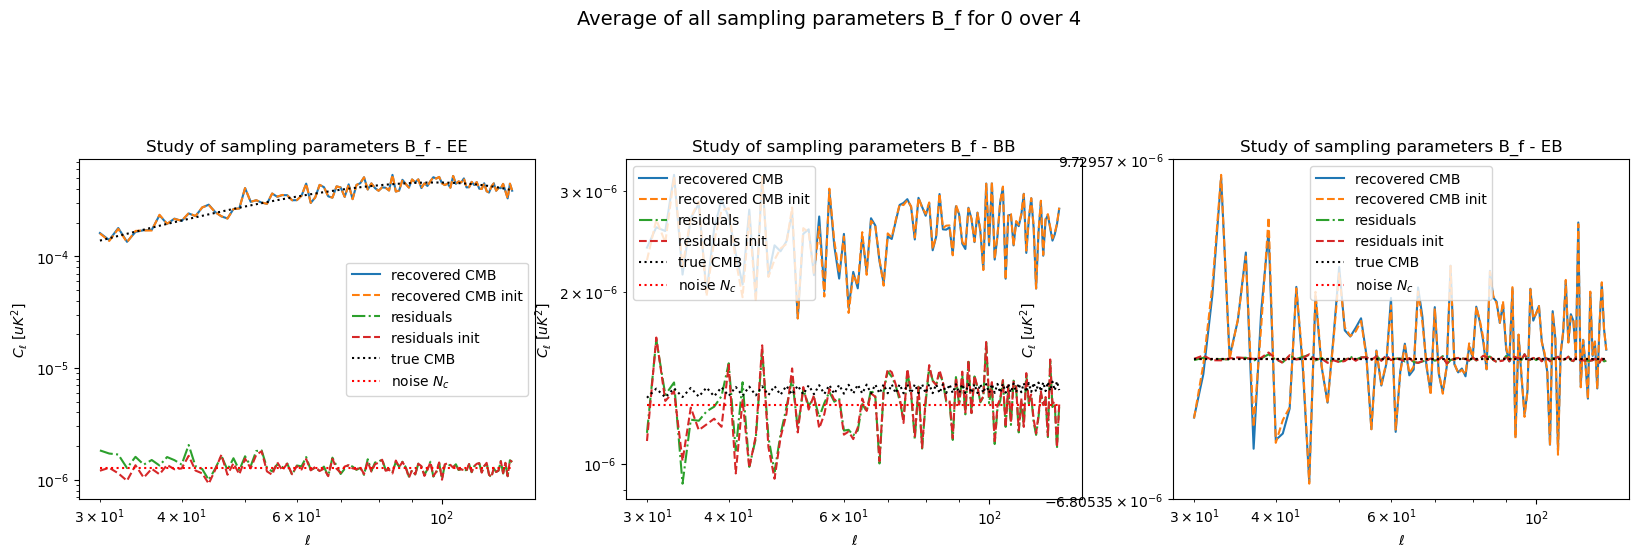

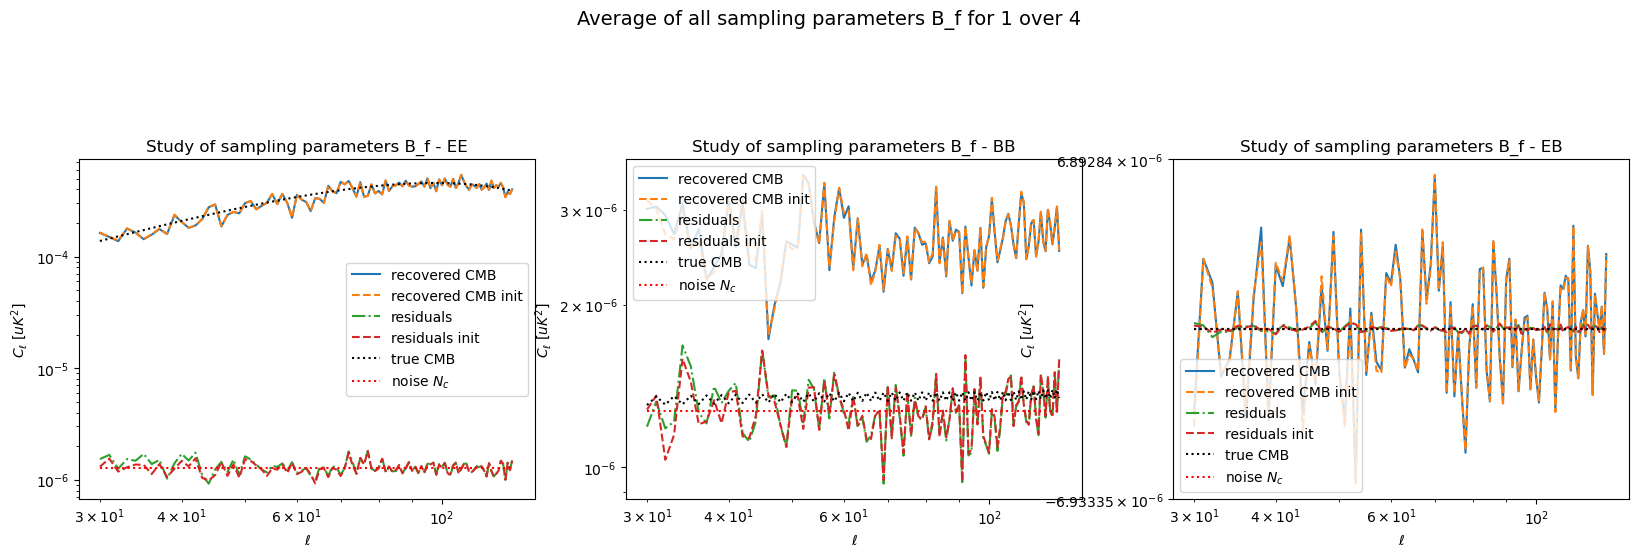

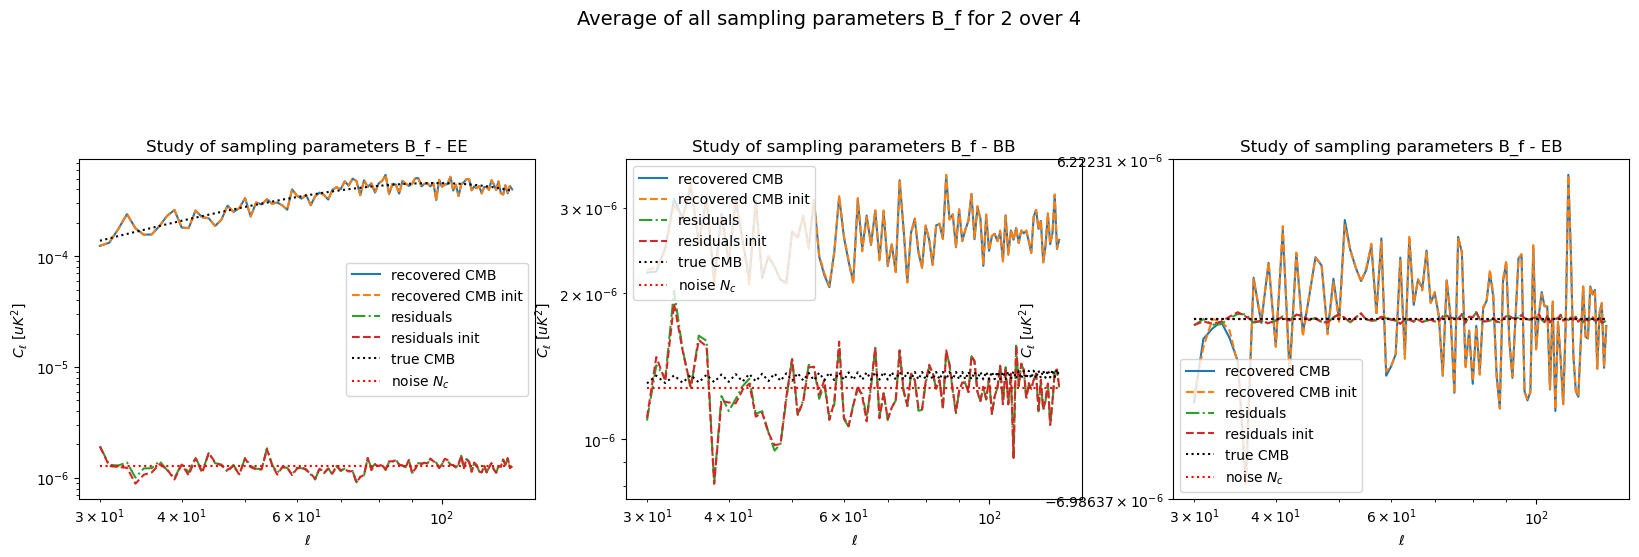

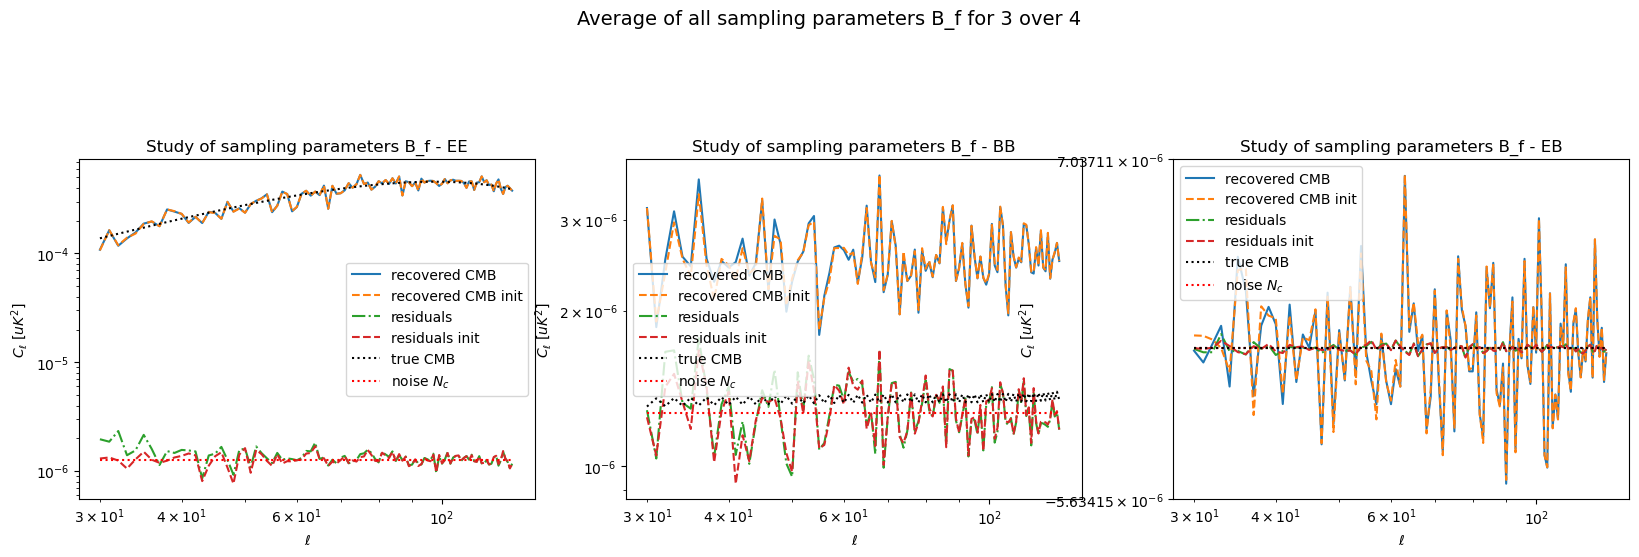

In [94]:
for job in range(num_jobs):
    final_params = all_params_mixing_matrix_samples[job,-1]
    final_params = all_params_mixing_matrix_samples[job].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,1000:].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,-1000:].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,0]
    # final_params = all_params_mixing_matrix_samples[job,:1000].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,1000]
    # final_params = all_params_mixing_matrix_samples[job,:num_sample_AM].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,num_sample_AM:].mean(axis=0)
    # final_params = all_params_mixing_matrix_samples[job,2000:].mean(axis=0)

    mixing_matrix_obj.update_params(final_params)
    final_mixing_matrix = mixing_matrix_obj.get_B()

    _cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), final_mixing_matrix, lmax)[0,0,lmin:]
    red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
    cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

    recovered_CMB_Wd = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, final_mixing_matrix, initial_freq_maps[job], jax_use=False)[0, :, :]

    mixing_matrix_obj.update_params(init_params)
    init_mixing_matrix_obj = mixing_matrix_obj.get_B()
    recovered_CMB_Wd_init = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, init_mixing_matrix_obj, initial_freq_maps[job], jax_use=False)[0, :, :]

    residuals_Wd = recovered_CMB_Wd - input_cmb_maps[job,0]
    residuals_Wd_init = recovered_CMB_Wd_init - input_cmb_maps[job,0]

    recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
    c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    recovered_CMB_Wd_init_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_init[0]), recovered_CMB_Wd_init])
    c_ells_recovered_CMB_Wd_init = hp.anafast(recovered_CMB_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
    c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    residuals_Wd_init_extended = np.vstack([np.zeros_like(residuals_Wd_init[0]), residuals_Wd_init])
    c_ells_residuals_Wd_init = hp.anafast(residuals_Wd_init_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

    plt.figure(figsize=(20,15))
    list_correl = ['EE', 'BB', 'EB']
    plt.suptitle(f"Average of all sampling parameters B_f for {job} over {num_jobs}", fontsize=14)
    number_subplots_convention = 331
    for i in range(number_correl_to_plot):
        plt.subplot(number_subplots_convention+i)
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd[i,:], label='recovered CMB')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_recovered_CMB_Wd_init[i,:], '--', label='recovered CMB init')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd[i,:], '-.', label='residuals')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_residuals_Wd_init[i,:], '--', label='residuals init')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[i,:], 'k:', label='true CMB')
        plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[i,:], 'r:', label='noise $N_c$')

        if i <= nstokes-1:
            plt.loglog()
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        else:
            plt.xscale('log')
            plt.yscale('symlog')
            plt.plot([lmin,lmax+1], [0,0], 'k:')
        plt.title('Study of sampling parameters B_f - {}'.format(list_correl[i]))
        plt.ylabel("$C_\ell$ [$uK^2$]")
        plt.xlabel(r"$\ell$")
        plt.legend()
plt.show()

In [95]:
# estimated_params = all_params_mixing_matrix_samples[-1000:].mean(axis=0)
# estimated_std = all_params_mixing_matrix_samples[-1000:].std(axis=0)

# Fisher_uncertainty = np.diag(sp.linalg.sqrtm(np.linalg.pinv(Fisher_matrix)))[:-1]

# print("Number of iterations", MICMAC_sampler_obj.number_iterations_sampling)
# for i in range(estimated_params.shape[0]*2):
#     j = i%(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
#     k = i//(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs)
#     if i>=MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs:
#         print('$B^d$ :', frequency_array[j], 'GHz')
#     else:
#         print('$B^s$ :', frequency_array[j], 'GHz')
#     print('Estimated :', estimated_params[j,k], "+-", estimated_std[j,k], '; Fisher :', Fisher_uncertainty[i])
#     print('Init params :', init_params[j,k])

# Autocorrelation length study

In [96]:
import numpyro.diagnostics
# from emcee import autocorr


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0,0]      0.34      0.00      0.34      0.34      0.34     17.20      1.00
Param:0[0,1]      0.01      0.00      0.01      0.01      0.01     13.85      1.00
Param:0[1,0]      0.03      0.00      0.03      0.03      0.03     21.05      1.04
Param:0[1,1]      0.05      0.00      0.05      0.05      0.05     10.40      1.01
Param:0[2,0]      0.01      0.00      0.01      0.01      0.01     19.55      1.03
Param:0[2,1]      0.13      0.00      0.13      0.13      0.13      9.77      1.01
Param:0[3,0]      0.00      0.00      0.00      0.00      0.00     14.25      1.04
Param:0[3,1]      0.44      0.00      0.44      0.44      0.44     14.20      1.00



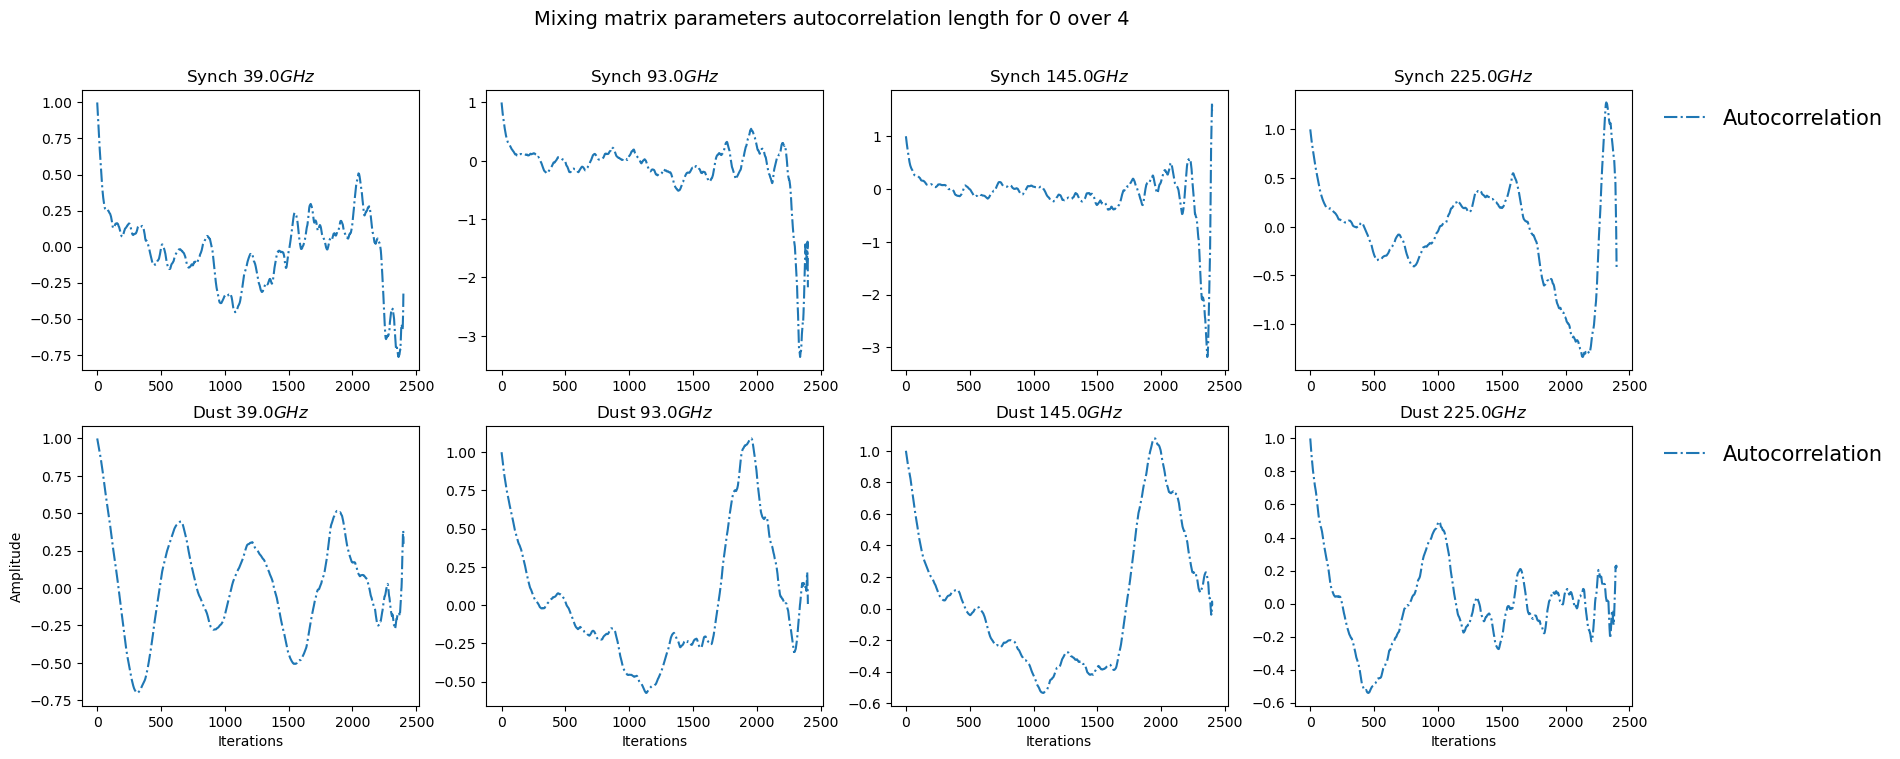


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0,0]      0.34      0.00      0.34      0.34      0.34     17.99      1.01
Param:0[0,1]      0.01      0.00      0.01      0.01      0.01      3.23      1.89
Param:0[1,0]      0.03      0.00      0.03      0.03      0.03      4.19      1.74
Param:0[1,1]      0.05      0.00      0.05      0.05      0.05      3.60      1.93
Param:0[2,0]      0.01      0.00      0.01      0.01      0.01      4.77      1.74
Param:0[2,1]      0.13      0.00      0.13      0.13      0.13      4.53      1.62
Param:0[3,0]      0.00      0.00      0.00      0.00      0.00      9.56      1.39
Param:0[3,1]      0.44      0.00      0.44      0.44      0.44      7.72      1.14



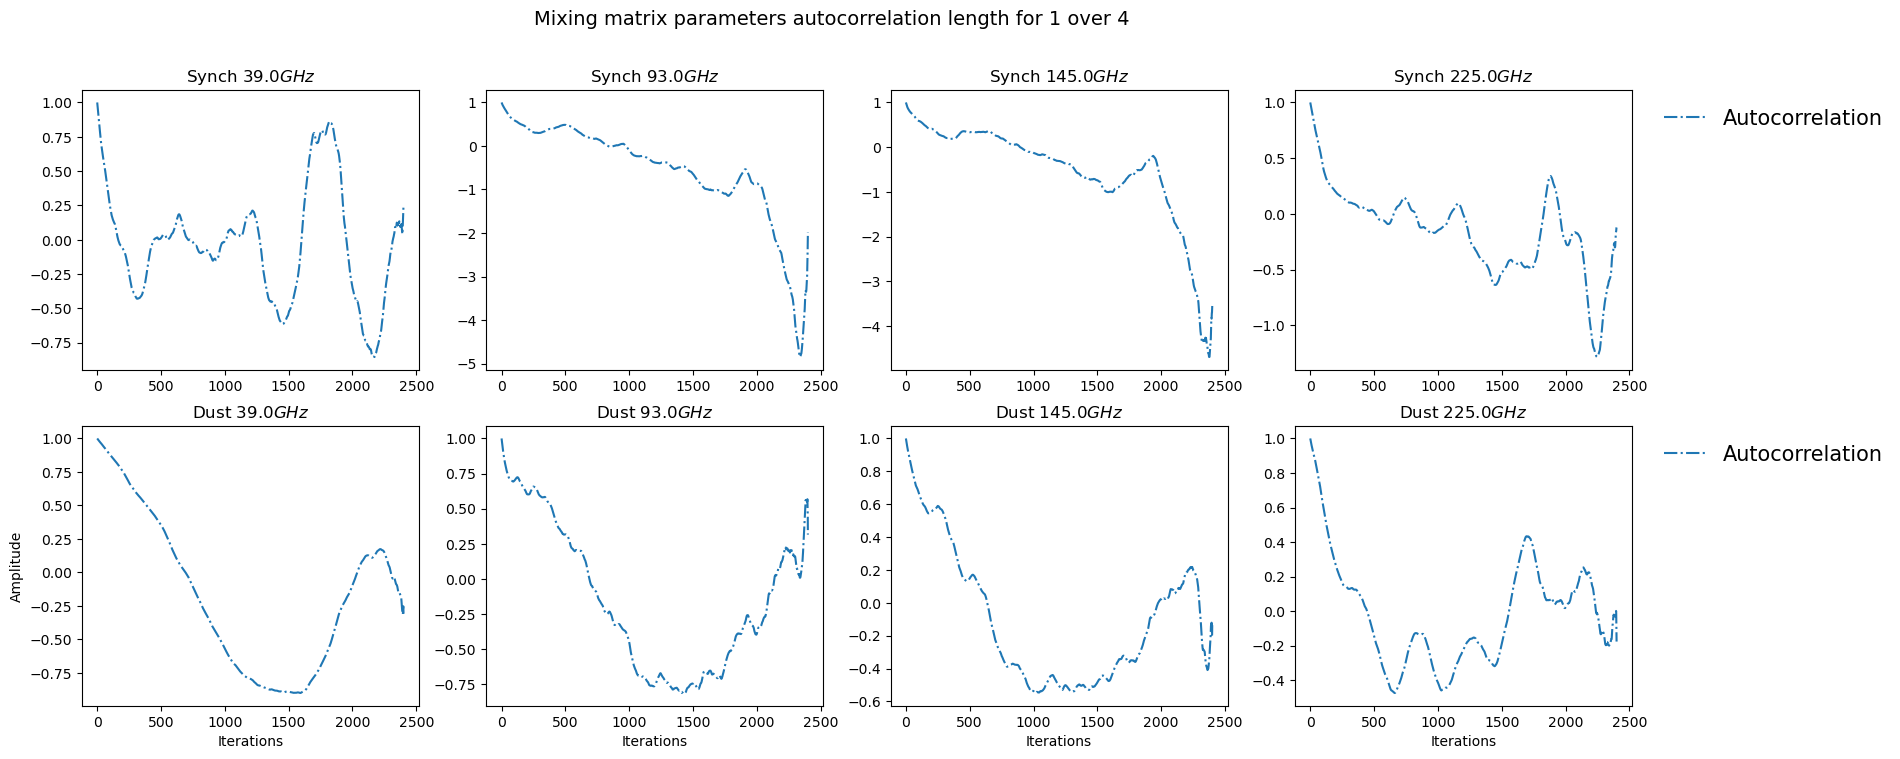


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0,0]      0.34      0.00      0.34      0.34      0.34      9.04      1.26
Param:0[0,1]      0.01      0.00      0.01      0.01      0.01      4.73      1.29
Param:0[1,0]      0.03      0.00      0.03      0.03      0.03     14.21      1.04
Param:0[1,1]      0.05      0.00      0.05      0.05      0.05      5.19      1.85
Param:0[2,0]      0.01      0.00      0.01      0.01      0.01     12.18      1.04
Param:0[2,1]      0.13      0.00      0.13      0.13      0.13      4.10      2.01
Param:0[3,0]      0.00      0.00      0.00      0.00      0.00     11.63      1.00
Param:0[3,1]      0.44      0.00      0.44      0.44      0.44      4.58      1.35



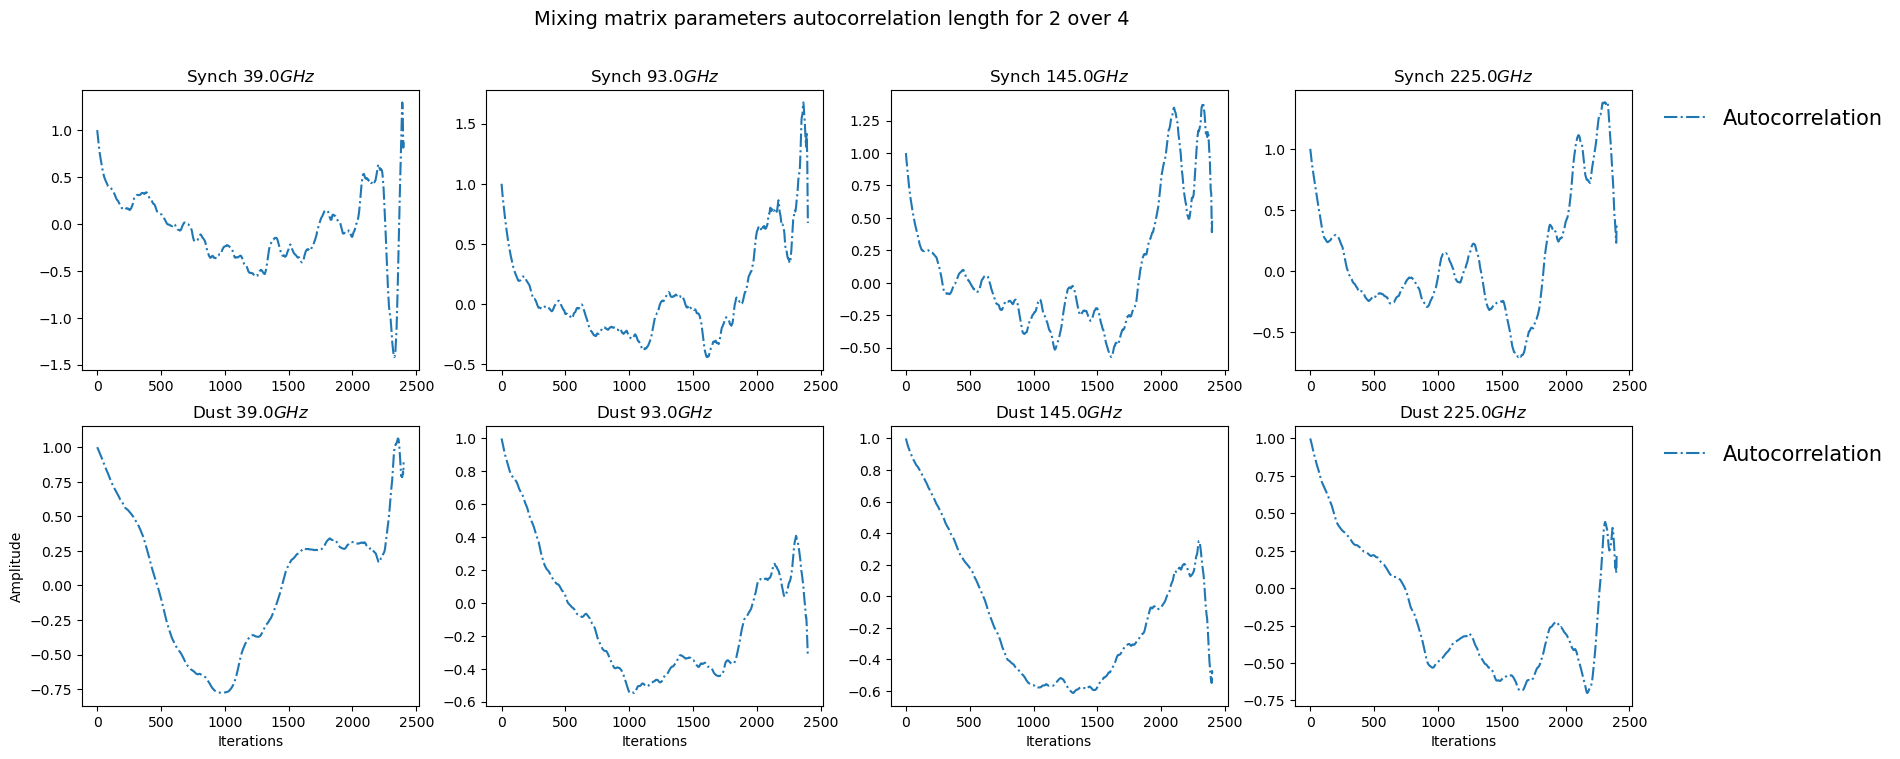


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0,0]      0.34      0.00      0.34      0.34      0.34     12.57      1.14
Param:0[0,1]      0.01      0.00      0.01      0.01      0.01      4.76      1.04
Param:0[1,0]      0.03      0.00      0.03      0.03      0.03     11.57      1.24
Param:0[1,1]      0.05      0.00      0.05      0.05      0.05      9.04      1.13
Param:0[2,0]      0.01      0.00      0.01      0.01      0.01     13.96      1.10
Param:0[2,1]      0.13      0.00      0.13      0.13      0.13     13.66      1.14
Param:0[3,0]      0.00      0.00      0.00      0.00      0.00     17.77      1.07
Param:0[3,1]      0.44      0.00      0.44      0.44      0.44     13.85      1.01



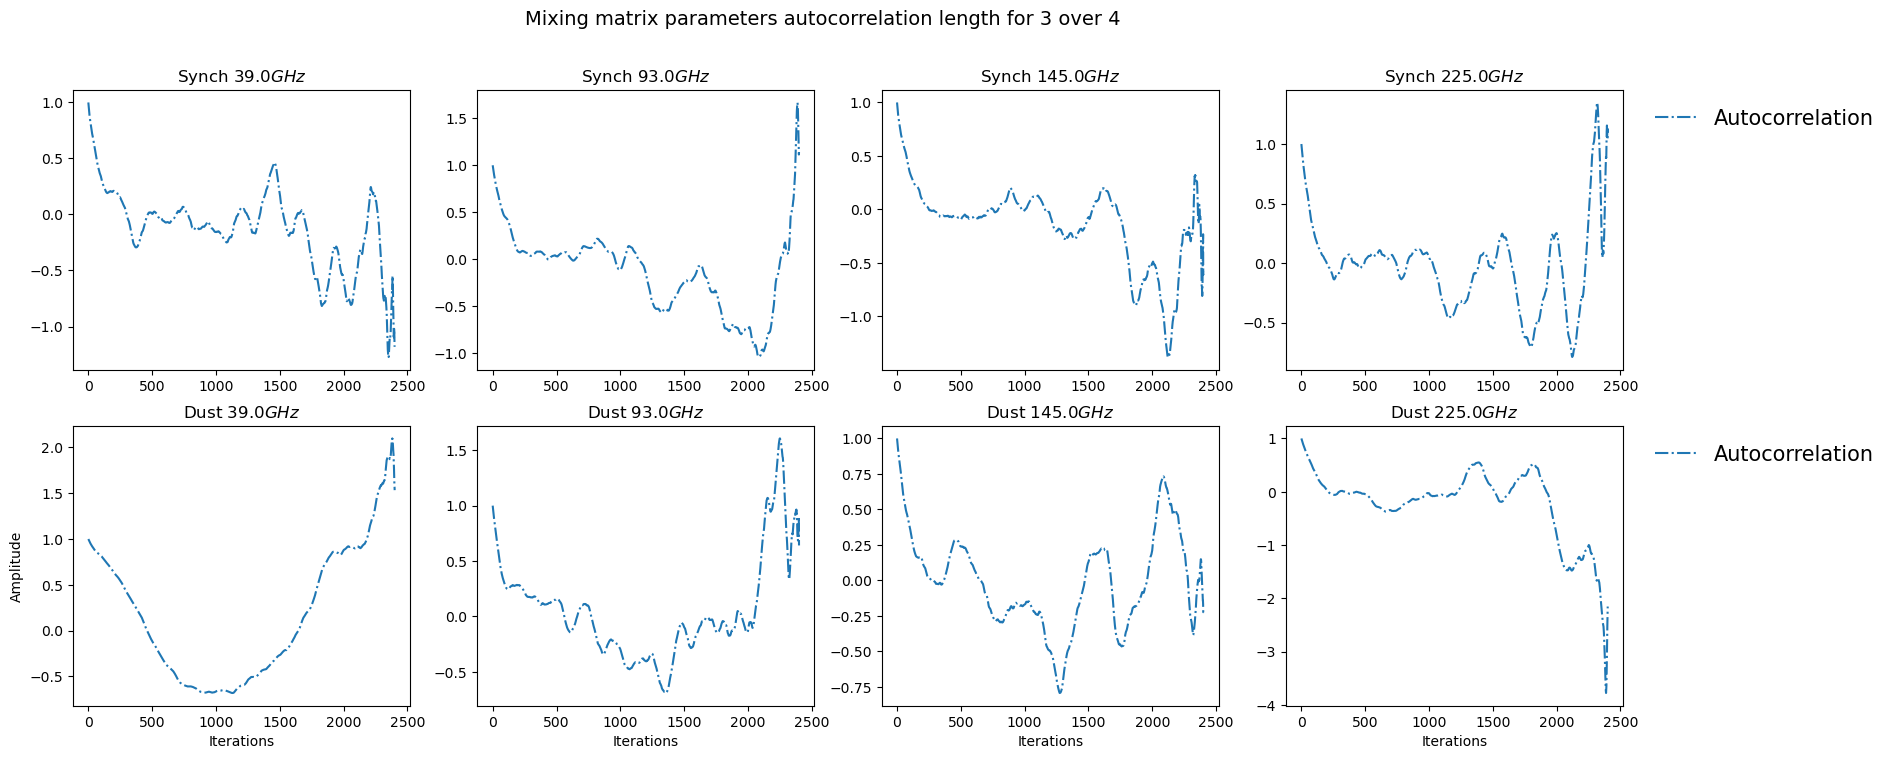

In [97]:
for job in range(num_jobs):
    aucorrelation_B_f = numpyro.diagnostics.autocorrelation(all_params_mixing_matrix_samples[job], axis=0)
    numpyro.diagnostics.print_summary(all_params_mixing_matrix_samples[job], prob=0.9, group_by_chain=False)

    list_correl = ['EE', 'BB', 'EB']

    ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + lmin

    frequency_Bf = np.array(instrument['frequency'][1:-1])
    all_B_f_autocorr_synch = aucorrelation_B_f[:,:,0]
    all_B_f_autocorr_dust = aucorrelation_B_f[:,:,1]

    frequency_array = np.array(instrument['frequency'])


    if MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs < 10:
        plt.figure(figsize=(20,8))
        plt.suptitle(f"Mixing matrix parameters autocorrelation length for {job} over {num_jobs}", fontsize=14)

        for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
            plt.subplot(201+len(frequency_Bf)*10+i)
            plt.title((f'Synch ${frequency_Bf[i]} GHz$'))
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,0],init_params[i,0]], label='Exact value')
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_synch[:,i], '-.', label='Autocorrelation')
            
            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_synch[:,i] - all_B_f_sample_synch[:,i].mean())/(all_B_f_sample_synch[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            # mean_B_f = np.round(all_B_f_sample_synch[:,i][cond].mean(), decimals=5)
            # std_B_f = np.round(all_B_f_sample_synch[:,i][cond].std(), decimals=5)

            # mean_value = all_B_f_sample_synch[:,i].mean()
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')

            # plt.yscale('log')
            # plt.xlabel('Iterations')
            # if i == 0:
            #     plt.ylabel('Amplitude')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

        # plt.figure(figsize=(20,8))
        # plt.subplot(122)
        for i in range(MICMAC_sampler_obj.number_frequencies-len_pos_special_freqs):
            plt.subplot(201+len(frequency_Bf)*10+i+len(frequency_Bf))
            # plt.subplot(201+len(frequency_Bf)*10+i)
            plt.title((f'Dust ${frequency_Bf[i]} GHz$'))
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [init_params[i,1],init_params[i,1]], label='Exact value')
            plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), all_B_f_autocorr_dust[:,i], '-.', label='Autocorrelation')

            # n_sigma = 3
            # transformed_samples = np.abs(all_B_f_sample_dust[:,i] - all_B_f_sample_dust[:,i].mean())/(all_B_f_sample_dust[:,i].std()) #< n_sigma
            # cond = np.exp(transformed_samples**2/2)/(np.sqrt(2*np.pi)) < 0.9973
            # mean_B_f = np.round(all_B_f_sample_dust[:,i][cond].mean(), decimals=5)
            # std_B_f = np.round(all_B_f_sample_dust[:,i][cond].std(), decimals=5)

            # mean_value = all_B_f_sample_dust[:,i].mean()
            # plt.plot([0,MICMAC_sampler_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean 99.7%')
            # plt.yscale('log')
            plt.xlabel('Iterations')
            if i == 0:
                plt.ylabel('Amplitude')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        # plt.loglog()

    plt.show()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0     -0.00      0.00     -0.00     -0.00     -0.00     44.08      1.00


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.00      0.00      0.00     -0.00      0.00     28.00      1.01


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0     -0.00      0.00     -0.00     -0.00      0.00     34.80      1.01


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0     -0.00      0.00     -0.00     -0.00     -0.00     39.07      1.00



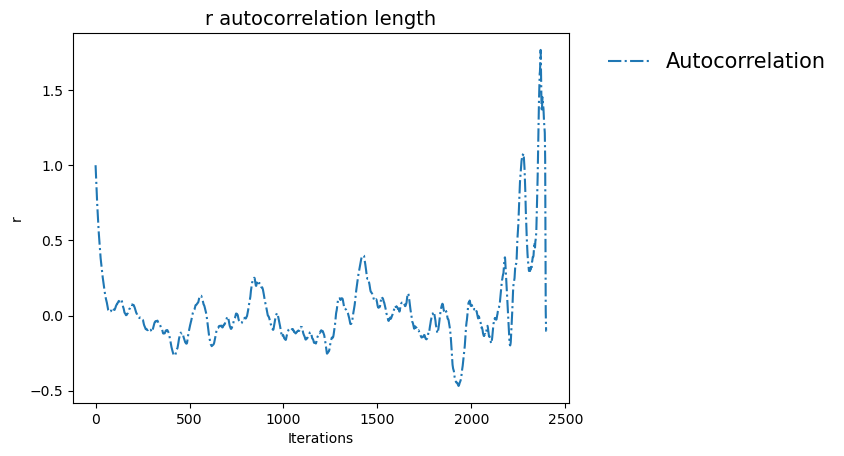

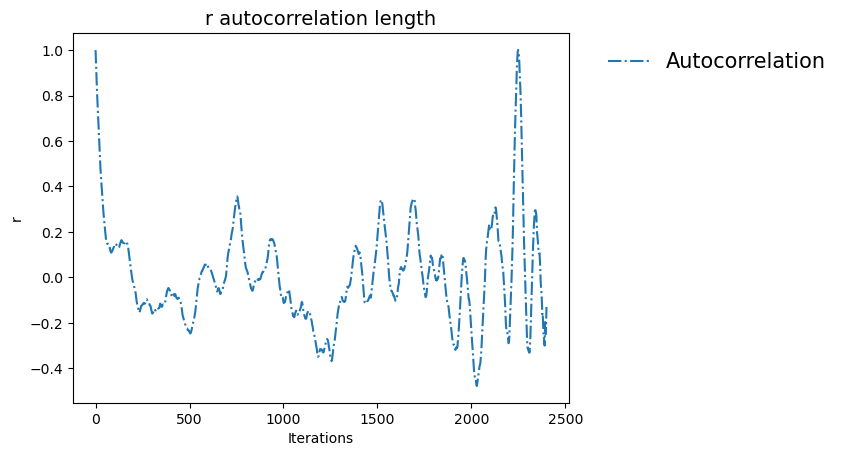

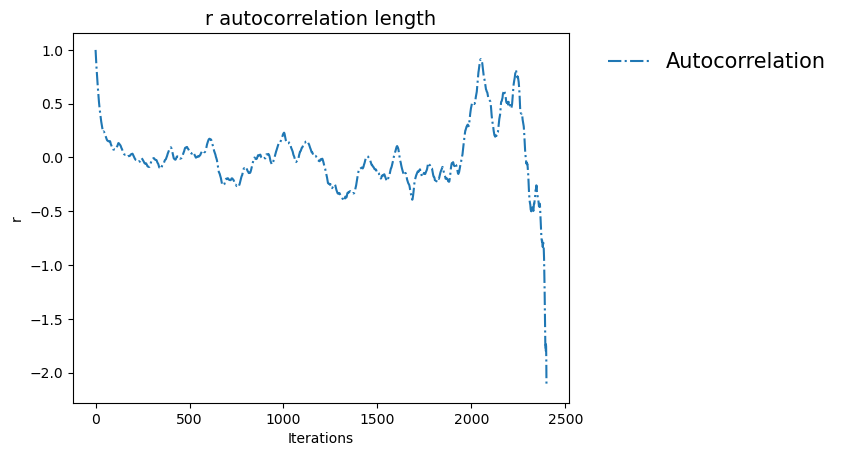

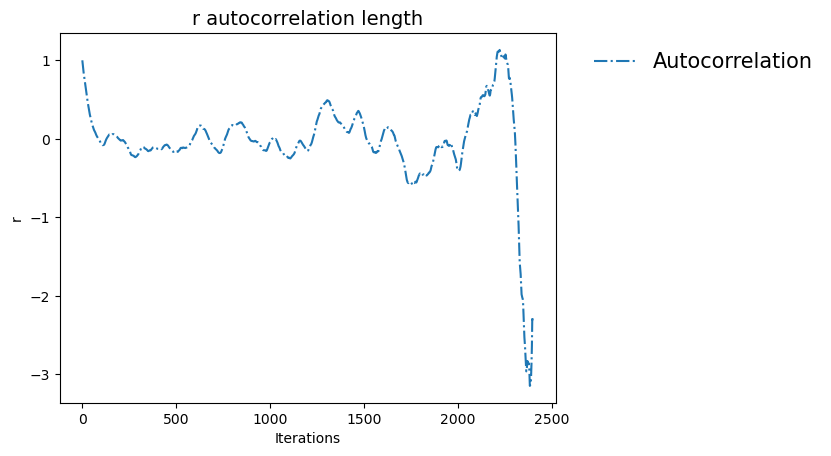

In [98]:
if MICMAC_sampler_obj.sample_r_Metropolis:
    for job in range(num_jobs):
        numpyro.diagnostics.print_summary(all_r_samples[job], prob=0.9, group_by_chain=False)
        aucorrelation_r = numpyro.diagnostics.autocorrelation(all_r_samples[job], axis=0)

        plt.figure()
        plt.title('r autocorrelation length', fontsize=14)
        plt.plot(np.arange(MICMAC_sampler_obj.number_iterations_sampling+1), aucorrelation_r, '-.', label='Autocorrelation')
        plt.xlabel('Iterations')
        plt.ylabel('r')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    plt.show()


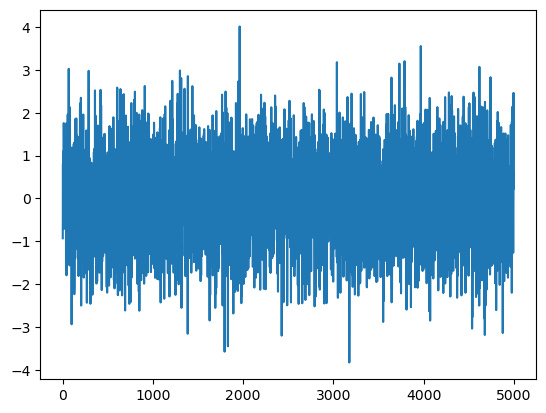

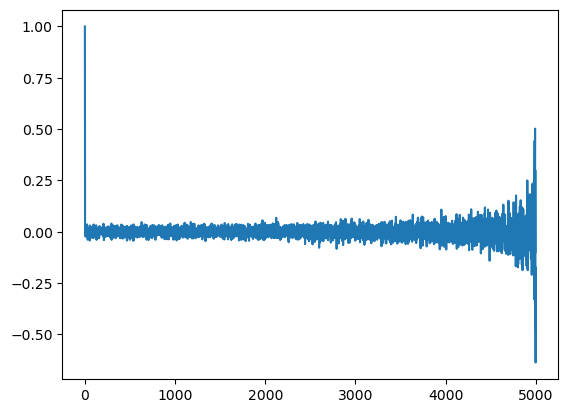

In [99]:
test_random = np.random.randn(5000)
# test_random = np.ones(1000)
# for i in range(10):
#     test_random[i*100:i*100 + 50] = -1
aucorr_random = numpyro.diagnostics.autocorrelation(test_random, axis=0)

plt.figure()
plt.plot(np.arange(test_random.shape[0]), test_random)
plt.figure()
plt.plot(np.arange(aucorr_random.shape[0]), aucorr_random)
plt.show()

In [100]:
for job in range(num_jobs):
    numpyro.diagnostics.effective_sample_size(jnp.array([all_params_mixing_matrix_samples[job,:]]))